In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import warnings
import icd9cms.icd9 as icd9
import os
import scipy.stats as ss
from sklearn.model_selection import train_test_split
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Loading the datasets

In [2]:
# Training datasets:

train_beneficiary = pd.read_csv('../data/Train_Beneficiarydata.csv')
train_inpatient = pd.read_csv('../data/Train_Inpatientdata.csv')
train_outpatient = pd.read_csv('../data/Train_Outpatientdata.csv')
train_labels = pd.read_csv('../data/Train_labels.csv')

In [3]:
print ("Training Data Shapes:")
print ("  Training Beneficiary Data Shape:  ", train_beneficiary.shape)
print ("  Training Inpatient Data Shape:    ", train_inpatient.shape)
print ("  Training Outpatient Data Shape:   ", train_outpatient.shape)
print ("  Training Labels Data Shape:       ", train_labels.shape)

Training Data Shapes:
  Training Beneficiary Data Shape:   (138556, 25)
  Training Inpatient Data Shape:     (40474, 30)
  Training Outpatient Data Shape:    (517737, 27)
  Training Labels Data Shape:        (5410, 2)


# Missing Values

In [4]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Create summary table
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'}
    )

    # Filter only columns that have missing values
    mis_val_table = mis_val_table[mis_val_table['Missing Values'] > 0]

    # Check if nothing is missing
    if mis_val_table.empty:
        print(f"This dataframe has {df.shape[1]} columns and {df.shape[0]} rows.")
        return "✔ No missing values found in any column."

    # Otherwise, sort and print summary
    mis_val_table = mis_val_table.sort_values('% of Total Values', ascending=False)

    print(f"This dataframe has {df.shape[1]} columns and {df.shape[0]} rows.")
    print(f"There are {mis_val_table.shape[0]} columns that have missing values.")

    return mis_val_table

## Missing values in Training Data

In [5]:
print("Missing values in Training Beneficiary Data:")
print(missing_values_table(train_beneficiary))

Missing values in Training Beneficiary Data:
This dataframe has 25 columns and 138556 rows.
There are 1 columns that have missing values.
     Missing Values  % of Total Values
DOD          137135          98.974422


In [6]:
print("Missing values in Training Inpatient Data:")
print(missing_values_table(train_inpatient))

Missing values in Training Inpatient Data:
This dataframe has 30 columns and 40474 rows.
There are 19 columns that have missing values.
                     Missing Values  % of Total Values
ClmProcedureCode_6            40474         100.000000
ClmProcedureCode_5            40465          99.977764
ClmProcedureCode_4            40358          99.713396
ClmProcedureCode_3            39509          97.615753
ClmDiagnosisCode_10           36547          90.297475
OtherPhysician                35784          88.412314
ClmProcedureCode_2            35020          86.524683
ClmProcedureCode_1            17326          42.807728
OperatingPhysician            16644          41.122696
ClmDiagnosisCode_9            13497          33.347334
ClmDiagnosisCode_8             9942          24.563918
ClmDiagnosisCode_7             7258          17.932500
ClmDiagnosisCode_6             4838          11.953353
ClmDiagnosisCode_5             2894           7.150269
ClmDiagnosisCode_4             1534    

In [7]:
print("Missing values in Training Outpatient Data:")
print(missing_values_table(train_outpatient))

Missing values in Training Outpatient Data:
This dataframe has 27 columns and 517737 rows.
There are 20 columns that have missing values.
                       Missing Values  % of Total Values
ClmProcedureCode_6             517737         100.000000
ClmProcedureCode_5             517737         100.000000
ClmProcedureCode_4             517735          99.999614
ClmProcedureCode_3             517733          99.999227
ClmProcedureCode_2             517701          99.993047
ClmProcedureCode_1             517575          99.968710
ClmDiagnosisCode_10            516654          99.790820
ClmDiagnosisCode_9             502899          97.134066
ClmDiagnosisCode_8             494825          95.574587
ClmDiagnosisCode_7             484776          93.633640
ClmDiagnosisCode_6             468981          90.582864
ClmDiagnosisCode_5             443393          85.640586
OperatingPhysician             427120          82.497484
ClmAdmitDiagnosisCode          412312          79.637345
ClmDiag

In [8]:
print("Missing values in Training Labels Data:")
print(missing_values_table(train_labels))

Missing values in Training Labels Data:
This dataframe has 2 columns and 5410 rows.
✔ No missing values found in any column.


## Findings on Missing Values

```ClmProcedureCode_6``` is 100% missing in training for both inpatient and outpatient datasets. Therefor Its dropped

In [9]:
# Dropping columns with 100% missing values in both inpatient and outpatient training datasets
train_inpatient = train_inpatient.drop(columns=['ClmProcedureCode_6'])
train_outpatient = train_outpatient.drop(columns=['ClmProcedureCode_6'])

Checking the columns of all datasets after dropping the columns with 100% missing values.

In [10]:
datasets = {
    "train_beneficiary": train_beneficiary,
    "train_inpatient": train_inpatient,
    "train_outpatient": train_outpatient,
    "train_labels": train_labels
}

for name, df in datasets.items():
    print(f"\n{name} columns:")
    print(list(df.columns))


train_beneficiary columns:
['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

train_inpatient columns:
['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmD

Further analysis and handling will be done on missing values later after merging.

# Merging Datasets

## Data Merging

### Merging Outpatient & Inpatient (each alone) with Beneficiary & Labels

In [11]:
# Merge Outpatient Data

# First merge with Beneficiary data to get patient details
train_outpatient_merged = pd.merge(train_outpatient, train_beneficiary, on='BeneID', how='left')

# Then merge with Labels to attach the fraud flag to every claim
train_outpatient_merged = pd.merge(train_outpatient_merged, train_labels, on='Provider', how='left')

print(f"Shape of train_outpatient_merged: {train_outpatient_merged.shape}")

Shape of train_outpatient_merged: (517737, 51)


In [12]:
# Merge Train Inpatient Data

# First merge with Beneficiary data to get patient details
train_inpatient_merged = pd.merge(train_inpatient, train_beneficiary, on='BeneID', how='left')

# Then merge with Labels to attach the fraud flag to every claim
train_inpatient_merged = pd.merge(train_inpatient_merged, train_labels, on='Provider', how='left')

print(f"Shape of train_inpatient_merged: {train_inpatient_merged.shape}")

Shape of train_inpatient_merged: (40474, 54)


In [13]:
# Get the sets of columns from both merged dataframes
inpatient_cols = set(train_inpatient_merged.columns)
outpatient_cols = set(train_outpatient_merged.columns)

# Find columns present in Inpatient but NOT in Outpatient
inpatient_only = inpatient_cols - outpatient_cols

# Find columns present in Outpatient but NOT in Inpatient
outpatient_only = outpatient_cols - inpatient_cols

print(f"Columns unique to Inpatient Data : {len(inpatient_only)} ")
print(list(inpatient_only))

print(f"\n Columns unique to Outpatient Data : {len(outpatient_only)}")
print(list(outpatient_only))

Columns unique to Inpatient Data : 3 
['DischargeDt', 'DiagnosisGroupCode', 'AdmissionDt']

 Columns unique to Outpatient Data : 0
[]


In [14]:
train_inpatient_merged['IsInpatient'] = 1
train_outpatient_merged['IsInpatient'] = 0

### Investigating the differences in columns between Inpatient & Outpatient

#### AdmissionDt vs ClaimStartDt

In [15]:
# Check rows where ClaimStartDt != AdmissionDt
inpatient_start_date_mismatch = train_inpatient_merged[train_inpatient_merged['ClaimStartDt'] != train_inpatient_merged['AdmissionDt']]
print(f"Rows with mismatched Start dates: {len(inpatient_start_date_mismatch)}")
inpatient_start_date_mismatch[['ClaimStartDt','AdmissionDt']]

Rows with mismatched Start dates: 32


ClaimStartDt AdmissionDt
2163    2009-02-10  2009-02-08
4422    2009-10-02  2009-09-29
5400    2009-09-12  2009-09-09
5647    2009-03-07  2009-03-02
5869    2009-07-10  2009-07-06
7828    2009-04-20  2009-04-16
7869    2009-11-01  2009-10-24
9051    2009-11-26  2009-11-18
9215    2009-01-11  2009-01-06
11103   2009-03-28  2009-03-26
11570   2009-11-14  2009-11-13
12418   2009-07-16  2009-07-14
12763   2009-03-18  2009-03-04
13660   2009-09-13  2009-09-11
13974   2009-08-31  2009-08-29
16043   2009-08-19  2009-08-18
17023   2009-01-16  2008-12-30
17581   2009-01-26  2008-12-29
18270   2009-10-21  2009-10-18
22977   2009-08-22  2009-08-21
24250   2009-04-24  2009-04-15
25600   2009-02-26  2009-01-30
27400   2009-02-15  2009-02-04
27576   2009-04-07  2009-04-06
28093   2009-05-22  2009-05-20
28246   2009-04-21  2009-03-26
28355   2009-11-17  2009-11-14
28398   2009-03-18  2009-03-16
29157   2009-03-02  2009-02-21
31734   2009-08-19  2009-07-24
35222   2009-11-19  2009-11-15
39683   2009-04-10  2009-04-09

##### Data Decision: Standardizing Start Dates

After taking closer look at the `AdmissionDt` and `ClaimStartDt` columns in the Inpatient data to see if they were redundant. It turns out they are **99.91% identical**, but the few exceptions are really important.

In the 32 cases where they differ, the **Admission Date always comes earlier**.

This difference tells me that the patient was physically admitted to the hospital *before* the specific billing period for the claim officially started.

If I strictly used `ClaimStartDt`, I would be calculating a "Length of Stay" that is shorter than reality. Since checking for extended, unnecessary hospital stays is a key part of detecting fraud, I need the most accurate physical start date possible, not just the billing date.

To capture the true duration of service while keeping my column names consistent for the eventual merge with Outpatient data (which lacks admission dates), I am going to overwrite `ClaimStartDt` with the values from `AdmissionDt`. This ensures `ClaimStartDt` always represents the *true* beginning of the service ,
Once that's done, I will drop `AdmissionDt` entirely. This prevents redundancy and ensures I always use the corrected `ClaimStartDt` for my analysis.

In [16]:
# Overwrite ClaimStartDt with AdmissionDt for Inpatient Data
# This captures the true start of the service (which we found is sometimes earlier than the claim start)
# while maintaining a common column name for future merging with Outpatient data.
train_inpatient_merged['ClaimStartDt'] = train_inpatient_merged['AdmissionDt']

# Verify the change
print("Sanity Check: \n")
print(f"Are ClaimStartDt and AdmissionDt now identical? \n {train_inpatient_merged['ClaimStartDt'].equals(train_inpatient_merged['AdmissionDt'])}")

train_inpatient_merged.drop(columns=['AdmissionDt'], inplace=True, axis=1)

print(f"Columns in Inpatient Data: {list(train_inpatient_merged.columns)} ")
print(f"\n Is 'AdmissionDt' still present? {'AdmissionDt' in train_inpatient_merged.columns}")

Sanity Check: 

Are ClaimStartDt and AdmissionDt now identical? 
 True
Columns in Inpatient Data: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', '

#### DischargeDt vs ClaimEndDt

In [17]:
# Check rows where ClaimEndDt != DischargeDt
inpatient_end_date_mismatch = train_inpatient_merged[train_inpatient_merged['ClaimEndDt'] != train_inpatient_merged['DischargeDt']]
print(f"Rows with mismatched Start dates: {len(inpatient_end_date_mismatch)}")
inpatient_end_date_mismatch

Rows with mismatched Start dates: 17


BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
35      BENE11093  CLM82202   2009-01-03  2009-01-12  PRV51842   
3864    BENE24807  CLM82212   2008-12-31  2009-01-11  PRV54111   
7752    BENE39346  CLM82211   2009-02-18  2009-02-26  PRV54065   
9094    BENE44545  CLM82209   2009-01-18  2009-01-27  PRV52843   
9974    BENE47786  CLM82208   2009-05-27  2009-06-04  PRV52828   
17060   BENE73681  CLM82213   2009-02-10  2009-02-21  PRV54354   
18267   BENE78133  CLM82210   2009-01-02  2009-01-05  PRV53461   
21298   BENE88968  CLM82205   2009-02-23  2009-02-28  PRV52045   
26395  BENE107828  CLM82216   2009-01-01  2009-01-22  PRV55018   
27053  BENE110116  CLM82217   2009-02-09  2009-03-17  PRV56268   
28753  BENE116436  CLM82206   2008-12-26  2009-01-04  PRV52178   
29584  BENE119457  CLM82220   2009-02-20  2009-03-03  PRV57547   
29727  BENE119908  CLM82218   2009-01-03  2009-01-29  PRV57191   
32874  BENE131263  CLM82201   2009-01-17  2009-01-25  PRV51021   
34668  BENE138446  CLM82214   2009-01-08  2009-01-12  PRV54955   
39612  BENE156020  CLM82204   2008-12-01  2009-01-06  PRV52019   
39821  BENE156866  CLM82219   2009-01-21  2009-01-28  PRV57409   

       InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
35                      20000          PHY341192          PHY355416   
3864                    13000          PHY360669          PHY408812   
7752                    19000          PHY337531          PHY341176   
9094                    14000          PHY365072                NaN   
9974                    14000          PHY391167                NaN   
17060                   11000          PHY397703                NaN   
18267                   20000          PHY331754          PHY426843   
21298                   24000          PHY339550          PHY359571   
26395                   19000          PHY364322          PHY320450   
27053                   20000          PHY400645          PHY408610   
28753                   14000          PHY329415          PHY393569   
29584                   16000          PHY327725                NaN   
29727                   16000          PHY329192          PHY346614   
32874                   12000          PHY424284                NaN   
34668                   11000          PHY352488          PHY352488   
39612                   11000          PHY393952          PHY348831   
39821                   20000          PHY415120          PHY423087   

      OtherPhysician ClmAdmitDiagnosisCode  DeductibleAmtPaid DischargeDt  \
35               NaN                  4439             1068.0  2009-01-09   
3864             NaN                 55221             1068.0  2009-01-09   
7752             NaN                 44421             1068.0  2009-02-23   
9094             NaN                 85181             1068.0  2009-01-25   
9974             NaN                   486             1068.0  2009-06-01   
17060      PHY390453                 78079             1068.0  2009-02-18   
18267            NaN                 72981             1068.0  2009-01-03   
21298            NaN                 78650             1068.0  2009-02-25   
26395            NaN                 78900             1068.0  2009-01-19   
27053            NaN                 25010             1068.0  2009-03-16   
28753            NaN                 78930             1068.0  2009-01-03   
29584            NaN                 29630             1068.0  2009-02-28   
29727            NaN                 99649             1068.0  2009-01-28   
32874            NaN                  7802             1068.0  2009-01-24   
34668            NaN                 71536             1068.0  2009-01-10   
39612      PHY416093                 99859             1068.0  2009-01-03   
39821            NaN                  5789             1068.0  2009-01-27   

      DiagnosisGroupCode ClmDiagnosisCode_1 ClmDiagnosisCode_2  \
35                   255              99662               2639   
3864                 345

##### Feature Engineering: Post-Discharge Billing Flag

We identified inpatient claims where the billing period (`ClaimEndDt`) extends beyond the patient's discharge date (`DischargeDt`). In our analysis, **100% of these cases were labeled as Potential Fraud**.

We will create a specific boolean flag to capture this suspicious behavior:
**`IsPostDischargeBilling`**: A binary indicator (1 for Yes, 0 for No). If `ClaimEndDt > DischargeDt`, then **1**, else **0**. it explicitly marks claims that violate the logical timeline of a hospital stay.

Since outpatient Data lack a `DischargeDt`, this risk factor is irrelevant to them. We will set this flag to **0** (False) for all outpatient records.

After creating this flag, we will drop the `DischargeDt` column from the inpatient data to avoid redundancy and get ready.

In [18]:
# Create Feature: Post-Discharge Billing Flag (Inpatient)
train_inpatient_merged['IsPostDischargeBilling'] = np.where(
    train_inpatient_merged['ClaimEndDt'] > train_inpatient_merged['DischargeDt'],
    1,0
)

# Handle Outpatient Data
# The concept doesn't exist for Outpatient, so we flag them all as 0
train_outpatient_merged['IsPostDischargeBilling'] = 0

# Check the counts
flagged_counts = train_inpatient_merged['IsPostDischargeBilling'].value_counts()
print(f"Inpatient Claims Flagged (1): {flagged_counts.get(1, 0)}")
print(f"Inpatient Claims Normal (0): {flagged_counts.get(0, 0)}")

# Drop DischargeDt after creating the flag
train_inpatient_merged.drop(columns=['DischargeDt'], inplace=True, axis=1)

Inpatient Claims Flagged (1): 17
Inpatient Claims Normal (0): 40457


#### DiagnosisGroupCode

In [19]:
print(f"Unique Diagnosis Group Codes: {train_inpatient_merged['DiagnosisGroupCode'].nunique()}")

Unique Diagnosis Group Codes: 736


In [20]:
train_inpatient['DiagnosisGroupCode'].value_counts().head()

DiagnosisGroupCode
882    179
884    174
166    168
183    165
939    163
Name: count, dtype: int64

##### Data Alignment: Handling Diagnosis Codes

I noticed a structural mismatch: **Inpatient** data has a `DiagnosisGroupCode` (which is valuable), but **Outpatient** data does not. If I try to merge them into one master dataset now, the columns won't align.

Instead of engineering complex scores right now, I am simply **harmonizing the schemas**.

For Outpatient Data: I am adding the `DiagnosisGroupCode` column and filling it with **"Not applicable"**.

This ensures both datasets have the exact same set of columns. It honestly reflects that outpatient claims don't involve Diagnosis Groups, allowing me to concatenate them cleanly. I will handle the encoding of these codes (like calculating Risk Scores) in the modeling phase.

In [21]:
# Handle Outpatient Data
# Outpatient data lacks DiagnosisGroupCode, so we assign it to not applicable
train_outpatient_merged['DiagnosisGroupCode'] = 'Not applicable'

### Merging Inpatient and Outpatient Data

In [22]:
# Check shapes before merging
print(f"Shape of Inpatient Merged Data: {train_inpatient_merged.shape}")
print(f"Shape of Outpatient Merged Data: {train_outpatient_merged.shape}")

Shape of Inpatient Merged Data: (40474, 54)
Shape of Outpatient Merged Data: (517737, 54)


In [23]:
# Check columns before merging
print("Inpatient Data Columns:")
print(list(train_inpatient_merged.columns))
print("\nOutpatient Data Columns:")
print(list(train_outpatient_merged.columns), '\n')

inpatient_cols  = set(train_inpatient_merged.columns)
outpatient_cols = set(train_outpatient_merged.columns)

if inpatient_cols == outpatient_cols:
    print("Columns match perfectly.")
else:
    print("Column Mismatch detected :")
    print(f"In Inpatient only: {inpatient_cols - outpatient_cols}")
    print(f"In Outpatient only: {outpatient_cols - inpatient_cols}")

Inpatient Data Columns:
['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAn

In [24]:
# Perform the Merge (Concatenation)
train_merged = pd.concat([train_inpatient_merged, train_outpatient_merged], ignore_index=True)

print(f"Inpatient Rows: {train_inpatient_merged.shape[0]}")
print(f"Outpatient Rows: {train_outpatient_merged.shape[0]}")
print(f"Total Merged Rows: {train_merged.shape[0]}")
print(f"Total Columns: {train_merged.shape[1]}")

Inpatient Rows: 40474
Outpatient Rows: 517737
Total Merged Rows: 558211
Total Columns: 54


# Data Exploration & Feature Engineering

In [25]:
train_merged.shape

(558211, 54)

In [26]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 54 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   ClmAdmitDiagnosisCode            145899 non-null  object 
 10  DeductibleAmtPaid                557312 non-null  float64
 11  DiagnosisGroupCode               558211 non-null  object 
 12  Cl

In [27]:
# Calculate the number of null values
null_sum = train_merged.isnull().sum()

# Calculate the percentage of null values
null_pct = (train_merged.isnull().sum() / len(train_merged)) * 100

# Calculate the number of unique values
nunique = train_merged.nunique()

# Combine these into a single DataFrame for a clean view
summary_df = pd.DataFrame({
    'Null Count': null_sum,
    'Null Percentage': null_pct,
    'Unique Values': nunique
})

# Display the summary
print(summary_df)

                                 Null Count  Null Percentage  Unique Values
BeneID                                    0         0.000000         138556
ClaimID                                   0         0.000000         558211
ClaimStartDt                              0         0.000000            398
ClaimEndDt                                0         0.000000            366
Provider                                  0         0.000000           5410
InscClaimAmtReimbursed                    0         0.000000            438
AttendingPhysician                     1508         0.270149          82063
OperatingPhysician                   443764        79.497538          35315
OtherPhysician                       358475        64.218548          46457
ClmAdmitDiagnosisCode                412312        73.863109           4098
DeductibleAmtPaid                       899         0.161050             17
DiagnosisGroupCode                        0         0.000000            737
ClmDiagnosis

## ClaimStartDt and ClaimEndDt

In [28]:
# Convert to datetime data type
train_merged['ClaimStartDt'] = pd.to_datetime(train_merged['ClaimStartDt'], errors='coerce')
train_merged['ClaimEndDt'] = pd.to_datetime(train_merged['ClaimEndDt'], errors='coerce')

In [29]:
train_merged[['ClaimStartDt','ClaimEndDt']].describe()

ClaimStartDt                     ClaimEndDt
count                         558211                         558211
mean   2009-06-24 23:38:45.075643648  2009-06-26 17:07:35.601913600
min              2008-11-27 00:00:00            2008-12-28 00:00:00
25%              2009-03-27 00:00:00            2009-03-29 00:00:00
50%              2009-06-23 00:00:00            2009-06-24 00:00:00
75%              2009-09-22 00:00:00            2009-09-23 00:00:00
max              2009-12-31 00:00:00            2009-12-31 00:00:00

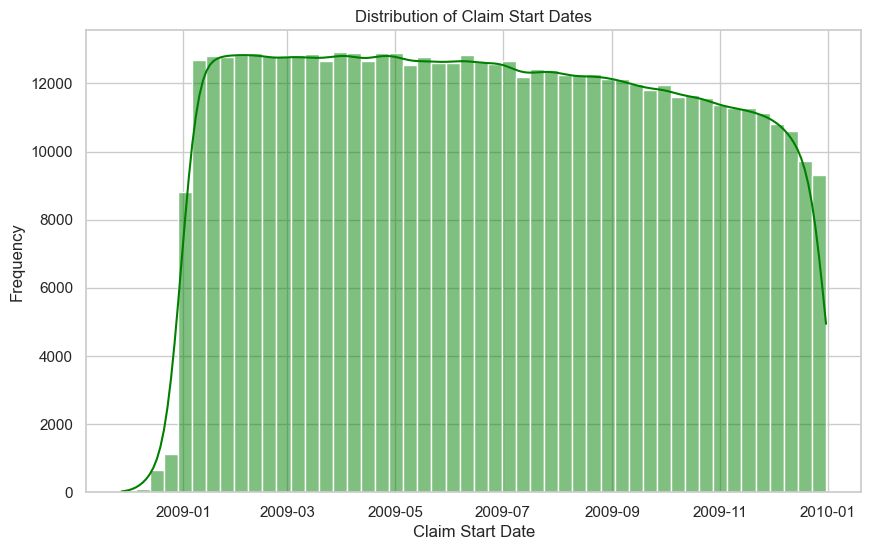

In [30]:
# Visualize Claim Start Dates Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_merged['ClaimStartDt'], bins=50, kde=True, color='green')
plt.title('Distribution of Claim Start Dates')
plt.xlabel('Claim Start Date')
plt.ylabel('Frequency')
plt.show()

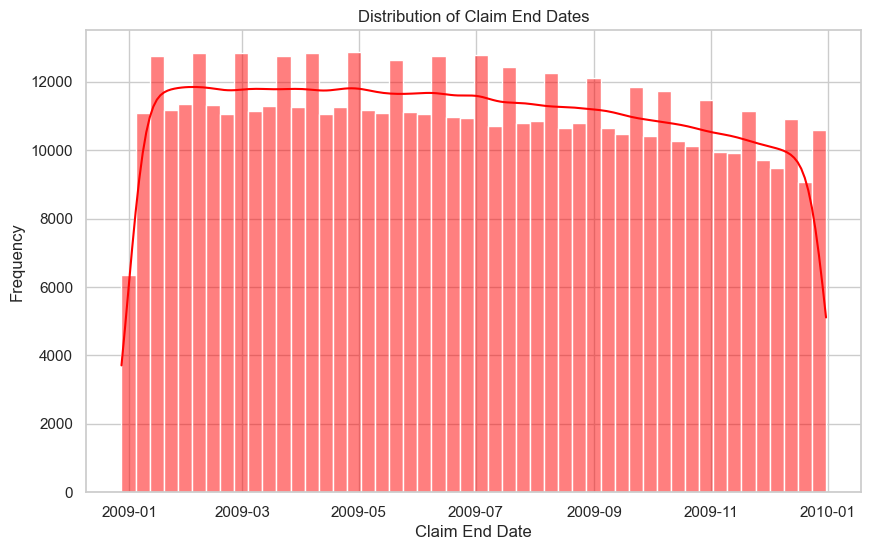

In [31]:
# Visualize Claim End Dates Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_merged['ClaimEndDt'], bins=50, kde=True, color='red')
plt.title('Distribution of Claim End Dates')
plt.xlabel('Claim End Date')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

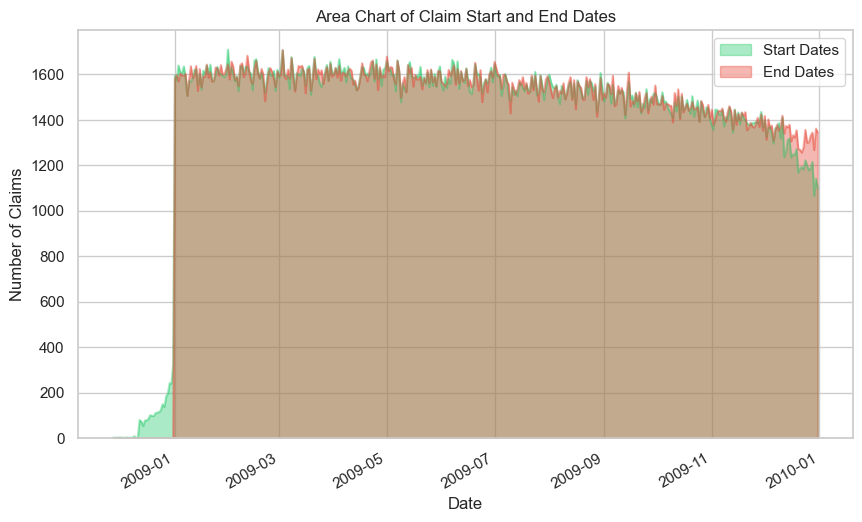

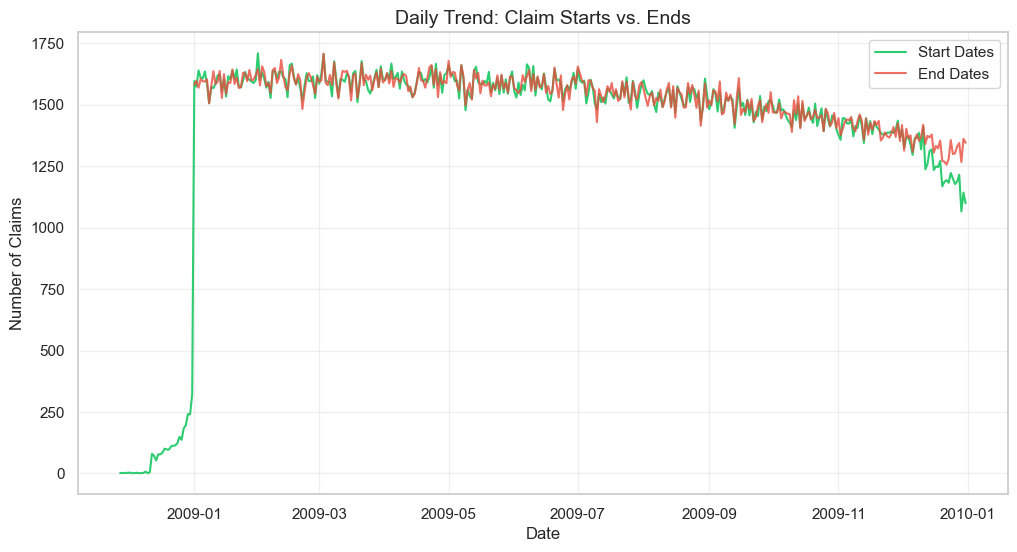

In [32]:
# Visualize Both Start and End Dates Together using Area Chart
plt.figure(figsize=(10, 6))
# Prepare data for area plot
start_dates = train_merged['ClaimStartDt'].value_counts().sort_index()
end_dates = train_merged['ClaimEndDt'].value_counts().sort_index()
# Create a DataFrame for plotting
date_df = pd.DataFrame({'Start Dates': start_dates, 'End Dates': end_dates})
# Plot area chart
date_df.plot.area(stacked=False,alpha=0.4, figsize=(10, 6), color=['#2ecc71', '#e74c3c'])
plt.title('Area Chart of Claim Start and End Dates')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.show()

# Visualize Both Start and End Dates Together using Line Chart
plt.figure(figsize=(12, 6))

# Using simple line plot
plt.plot(date_df.index, date_df['Start Dates'], label='Start Dates', color='#2ecc71', linewidth=1.5)
plt.plot(date_df.index, date_df['End Dates'], label='End Dates', color='#e74c3c', linewidth=1.5, alpha=0.8)

plt.title('Daily Trend: Claim Starts vs. Ends', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Feature Engineering: Claim Duration

In [33]:
# Calculate Claim Duration in Days
train_merged['ClaimDurationDays'] = (train_merged['ClaimEndDt'] - train_merged['ClaimStartDt']).dt.days
# Summary statistics of Claim Duration
print("Claim Duration (Days) Summary:")
print(train_merged['ClaimDurationDays'].describe())

Claim Duration (Days) Summary:
count    558211.000000
mean          1.728363
std           4.906205
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          36.000000
Name: ClaimDurationDays, dtype: float64


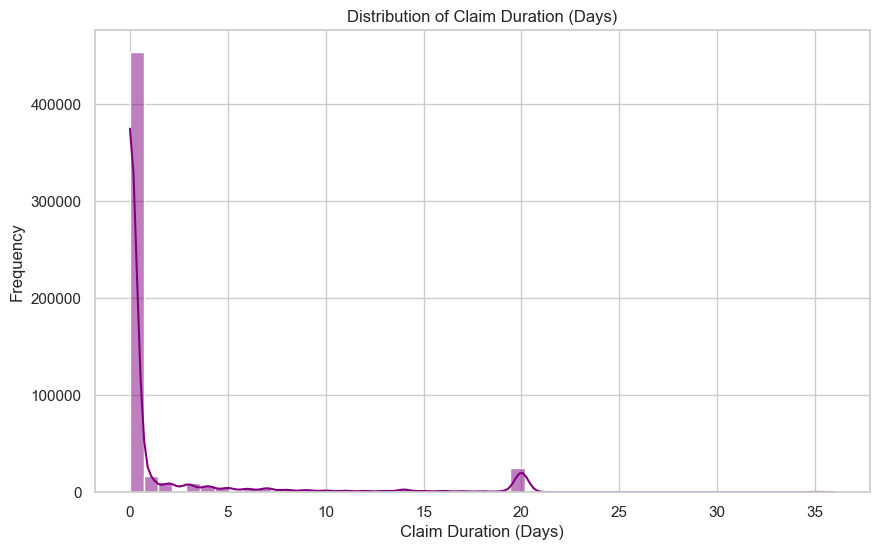

In [34]:
# Visualize Claim Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_merged['ClaimDurationDays'], bins=50, kde=True, color='purple')
plt.title('Distribution of Claim Duration (Days)')
plt.xlabel('Claim Duration (Days)')
plt.ylabel('Frequency')
plt.show()

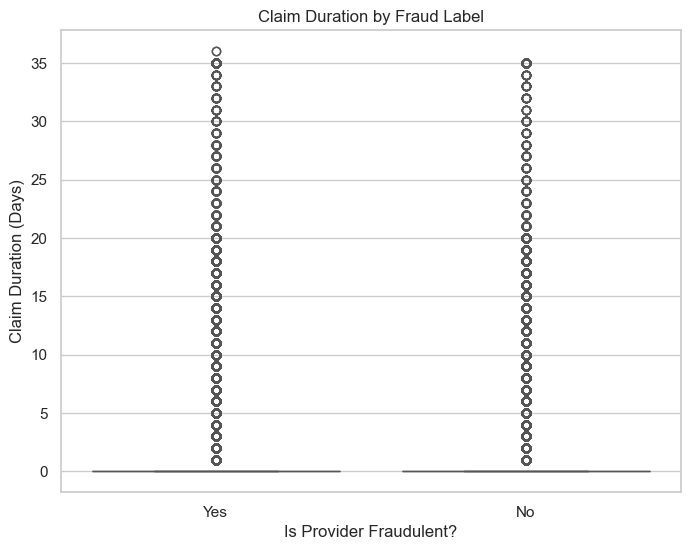

In [35]:
# Box Plot of Claim Duration by Fraud Label
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_merged, x='PotentialFraud', y='ClaimDurationDays', palette={'Yes': '#ff6b6b', 'No': '#4ecdc4'})
plt.title('Claim Duration by Fraud Label')
plt.xlabel('Is Provider Fraudulent?')
plt.ylabel('Claim Duration (Days)')
plt.show()

In [36]:
# Correlation between Original Dates and Fraud
date_correlation = train_merged[['ClaimStartDt', 'ClaimEndDt', 'PotentialFraud']].copy()
date_correlation['PotentialFraud'] = date_correlation['PotentialFraud'].map({'Yes': 1, 'No': 0})
date_correlation['ClaimStartDt'] = date_correlation['ClaimStartDt'].astype(np.int64) // 10**9  # Convert to seconds since epoch
date_correlation['ClaimEndDt'] = date_correlation['ClaimEndDt'].astype(np.int64) // 10**9  # Convert to seconds since epoch
correlation_matrix = date_correlation.corr()
print("Correlation Matrix between Claim Dates and Potential Fraud:")
print(correlation_matrix)

Correlation Matrix between Claim Dates and Potential Fraud:
                ClaimStartDt  ClaimEndDt  PotentialFraud
ClaimStartDt        1.000000    0.998892       -0.002507
ClaimEndDt          0.998892    1.000000       -0.001159
PotentialFraud     -0.002507   -0.001159        1.000000


In [37]:
# Correlation between Claim Duration and Fraud
fraud_correlation = train_merged[['ClaimDurationDays', 'PotentialFraud']].copy()
fraud_correlation['PotentialFraud'] = fraud_correlation['PotentialFraud'].map({'Yes': 1, 'No': 0})
correlation_value = fraud_correlation.corr().loc['ClaimDurationDays', 'PotentialFraud']
print(f"Correlation between Claim Duration and Potential Fraud: {correlation_value:.4f}")

Correlation between Claim Duration and Potential Fraud: 0.0287


In [38]:
# Drop original date columns after extracting duration as it has
# been proven that they have lower correlation with fraud than duration

# They will be dropped after we finish all date-related feature engineering
# as they are used in other features like DeathDuringClaim in DOD section
# train_merged.drop(columns=['ClaimStartDt', 'ClaimEndDt'], inplace=True, axis=1)

## DOB (Date of Birth)

In [39]:
train_merged['DOB'].value_counts(dropna=False).head()

DOB
1943-12-01    2072
1939-03-01    2030
1942-10-01    1989
1939-04-01    1984
1938-09-01    1971
Name: count, dtype: int64

#### Feature Engineering: Beneficiary Age

we will Calculate the exact age of each beneficiary to use as a demographic feature.

* **Reference Date:** We set the "current" date to **2010-01-01**. This roughly aligns with the dataset's timeline (2009 claims) and as if we are only 1 day after data delivered (earliest date in data is 31st of December 2009".
* **Formula:** Age = (2010-01-01 - Date of Birth (`DOB`) )/ **365.25**
(accounting for leap years) to get a precise float value , capturing the exact continuous age including months & days.

In [40]:
def calculate_age(df, ref_date_str='2010-01-01'):
    # Define Reference Date
    ref_date = pd.Timestamp(ref_date_str)

    # Ensure DOB is datetime
    df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')

    # Calculate Age in Days then convert to Years (float)
    # We use 365.25 to account for leap years over a lifetime
    df['Age'] = (ref_date - df['DOB']).dt.days / 365.25

    return df

# Apply the function to calculate age
print("Calculating Patient Ages (Reference: 2010-01-01)")
train_merged = calculate_age(train_merged)

print(f"Train Age Range: {train_merged['Age'].min():.1f} to {train_merged['Age'].max():.3f} years")

Calculating Patient Ages (Reference: 2010-01-01)
Train Age Range: 26.1 to 100.999 years


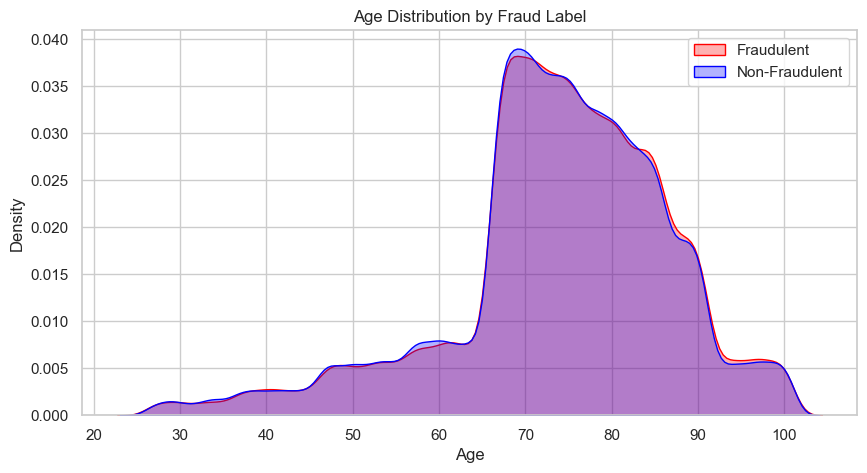

In [41]:
# Visualization: Age Distribution for Fraud vs Non-Fraud
plt.figure(figsize=(10, 5))
sns.kdeplot(data=train_merged[train_merged['PotentialFraud']=='Yes'], x='Age', label='Fraudulent', fill=True, color='red', alpha=0.3)
sns.kdeplot(data=train_merged[train_merged['PotentialFraud']=='No'], x='Age', label='Non-Fraudulent', fill=True, color='blue', alpha=0.3)
plt.title('Age Distribution by Fraud Label')
plt.legend()
plt.show()

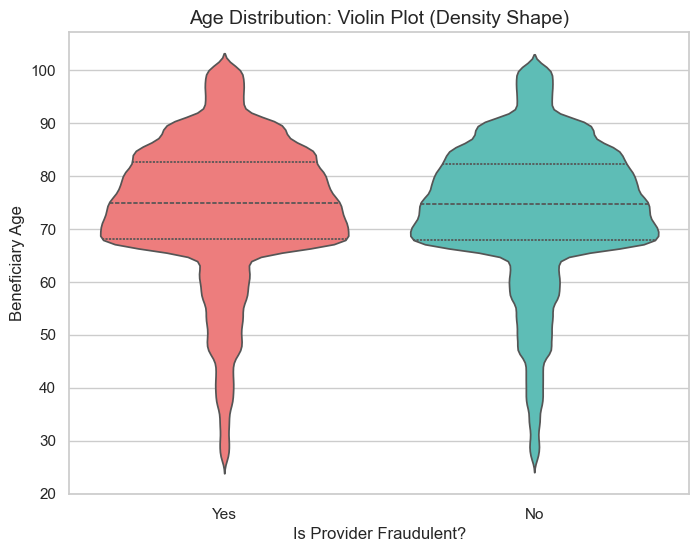

In [42]:
# Violin Plot (Density Shape)

plt.figure(figsize=(8, 6)) # Individual figure size

sns.violinplot(
    data=train_merged,
    x='PotentialFraud',
    y='Age',
    hue='PotentialFraud',
    palette={'Yes': '#ff6b6b', 'No': '#4ecdc4'}, # Custom clean colors
    inner='quartile' # Draws lines for 25%, 50%, 75%
)

plt.title('Age Distribution: Violin Plot (Density Shape)', fontsize=14)
plt.xlabel('Is Provider Fraudulent?')
plt.ylabel('Beneficiary Age')
plt.show()

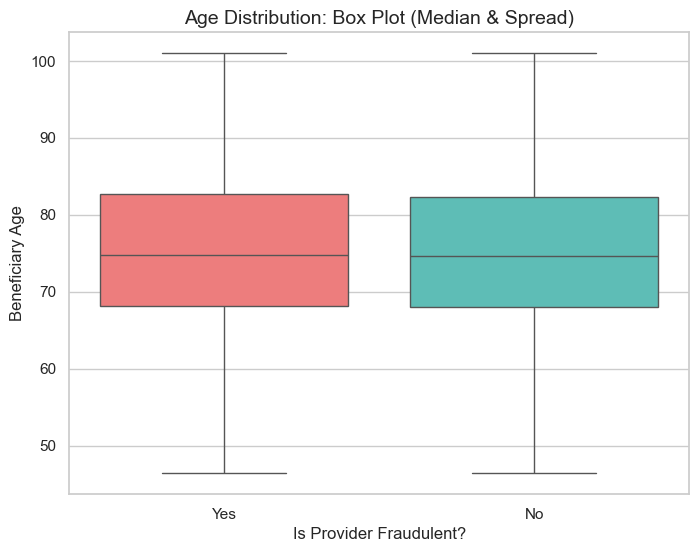

In [43]:
# Box Plot (Median & Spread)

plt.figure(figsize=(8, 6)) # Individual figure size

sns.boxplot(
    data=train_merged,
    x='PotentialFraud',
    y='Age',
    hue='PotentialFraud',
    palette={'Yes': '#ff6b6b', 'No': '#4ecdc4'},
    showfliers=False # Hides extreme outliers to keep the plot clean
)

plt.title('Age Distribution: Box Plot (Median & Spread)', fontsize=14)
plt.xlabel('Is Provider Fraudulent?')
plt.ylabel('Beneficiary Age')
plt.show()

In [44]:
# Drop original DOB column after extracting Age , as age is more useful for
# modeling and preserves the same exact info (sense it is a decimal value)
train_merged.drop(columns=['DOB'], inplace=True, axis=1)

## DOD (Date of Death)

In [45]:
train_merged['DOD'].value_counts(dropna=False)

DOD
NaN           554080
2009-12-01       710
2009-10-01       572
2009-11-01       560
2009-09-01       511
2009-08-01       482
2009-07-01       371
2009-06-01       295
2009-05-01       243
2009-04-01       166
2009-03-01       157
2009-02-01        64
Name: count, dtype: int64

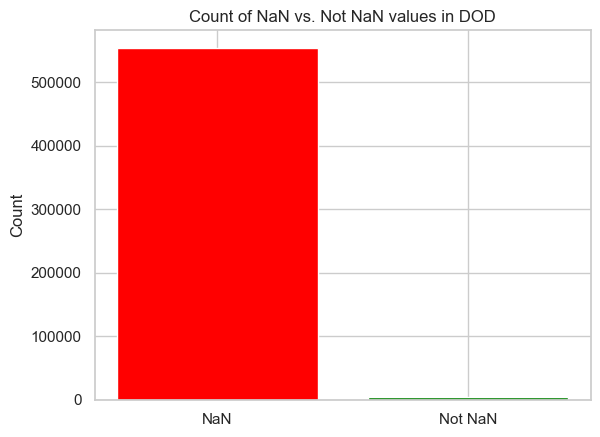

In [46]:
nan_count = train_merged['DOD'].isna().sum()
not_nan_count = train_merged['DOD'].notna().sum()

counts = {'NaN': nan_count, 'Not NaN': not_nan_count}
plt.bar(counts.keys(), counts.values(), color=['red', 'green'])
plt.title('Count of NaN vs. Not NaN values in DOD')
plt.ylabel('Count')
plt.show()

2025-12-03 13:43:09,795: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-03 13:43:09,901: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


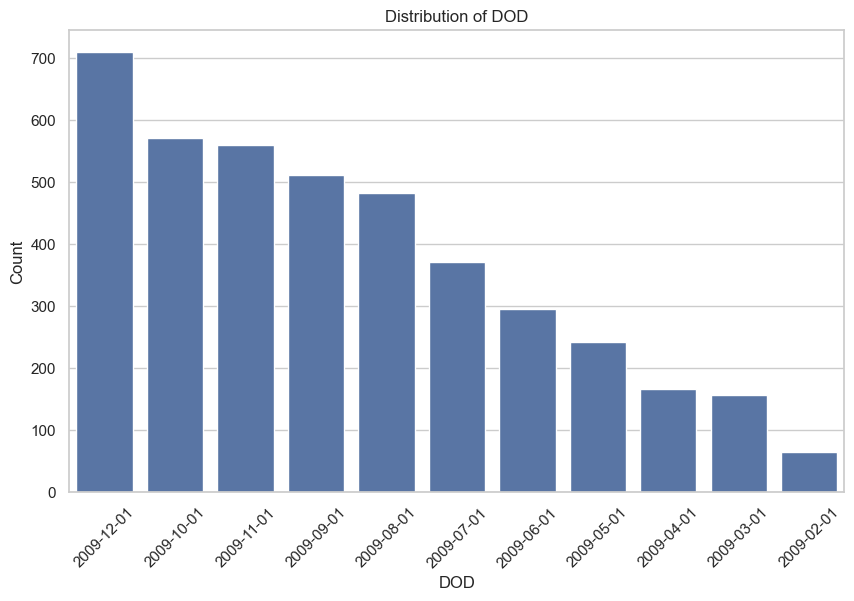

In [47]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_merged, x='DOD', order=train_merged['DOD'].value_counts().index)
plt.title('Distribution of DOD')
plt.xlabel('DOD')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [48]:
print("Count of Not NaN DOD values where PotentialFraud is Yes:")
print(train_merged['DOD'].notna()[train_merged['PotentialFraud'] == 'Yes'].sum())

print("Count of Not NaN DOD values where PotentialFraud is No:")
print(train_merged['DOD'].notna()[train_merged['PotentialFraud'] == 'No'].sum())

Count of Not NaN DOD values where PotentialFraud is Yes:
1544
Count of Not NaN DOD values where PotentialFraud is No:
2587


The Date of Death (DOD) column itself doesnt have meaning but from it we can derive a new feature called "Death During Claim" which indicates whether the patient died during the claim period.

where for DOD not null and DOD is between ClaimStartDt and ClaimEndDt we can say that the patient died during the claim period.

all other cases (nulls) we can say that the patient did not die during the claim period.

In [49]:
# Feature Engineering: Death During Claim

def create_death_flag(df):
    # Ensure datetime format
    df['DOD'] = pd.to_datetime(df['DOD'], errors='coerce')
    df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'], errors='coerce')
    df['ClaimEndDt'] = pd.to_datetime(df['ClaimEndDt'], errors='coerce')

    # Create the flag
    # Logic: DOD must exist AND be within the claim window
    df['DeathDuringClaim'] = np.where(
        (df['DOD'].notnull()) &
        (df['DOD'] >= df['ClaimStartDt']) &
        (df['DOD'] <= df['ClaimEndDt']),
        1,
        0
    )
    return df

train_merged = create_death_flag(train_merged)

# Verification
print("Death Flag Created.")
print(f"Train: {train_merged['DeathDuringClaim'].sum()} deaths during claim.")

# Quick relation to Fraud
if 'PotentialFraud' in train_merged.columns:
    print("\nFraud Rate for 'Death During Claim' cases:")
    print(train_merged[train_merged['DeathDuringClaim'] == 1]['PotentialFraud'].value_counts(normalize=True))

Death Flag Created.
Train: 21 deaths during claim.

Fraud Rate for 'Death During Claim' cases:
PotentialFraud
No     0.571429
Yes    0.428571
Name: proportion, dtype: float64


In [50]:
#not only it has a very small count , but it also there's
# no real significant relation between death during claim and potential fraud
#therfore we drop it
train_merged.drop(columns=['DeathDuringClaim'], inplace=True, axis=1)

#### Feature Engineering: IsDead Flag

In [51]:
# final idea , just keep a boolean flag indicating if DOD is present or not
# This is valuable: It tells us if the patient has a Date of Death recorded.
train_merged['IsDead'] = train_merged['DOD'].notnull().astype(int)
# drop the original DOD column
(train_merged.drop(columns=['DOD'], inplace=True, axis=1))
train_merged.shape

(558211, 55)

In [52]:
# Drop original date columns after extracting useful features as it has
# been proven that they have lower correlation with fraud than ClaimDurationDays

train_merged.drop(columns=['ClaimStartDt', 'ClaimEndDt'], inplace=True, axis=1)

In [53]:
train_merged.head()

BeneID   ClaimID  Provider  InscClaimAmtReimbursed AttendingPhysician  \
0  BENE11001  CLM46614  PRV55912                   26000          PHY390922   
1  BENE11001  CLM66048  PRV55907                    5000          PHY318495   
2  BENE11001  CLM68358  PRV56046                    5000          PHY372395   
3  BENE11011  CLM38412  PRV52405                    5000          PHY369659   
4  BENE11014  CLM63689  PRV56614                   10000          PHY379376   

  OperatingPhysician OtherPhysician ClmAdmitDiagnosisCode  DeductibleAmtPaid  \
0                NaN            NaN                  7866             1068.0   
1          PHY318495            NaN                  6186             1068.0   
2                NaN      PHY324689                 29590             1068.0   
3          PHY392961      PHY349768                   431             1068.0   
4          PHY398258            NaN                 78321             1068.0   

  DiagnosisGroupCode ClmDiagnosisCode_1 ClmDiagnosisCode_2 ClmDiagnosisCode_3  \
0                201               1970               4019               5853   
1                750               6186               2948              56400   
2                883              29623              30390              71690   
3                067              43491               2762               7843   
4                975                042               3051              34400   

  ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6 ClmDiagnosisCode_7  \
0               7843               2768              71590               2724   
1                NaN                NaN                NaN                NaN   
2              34590              V1581              32723                NaN   
3              32723              V1041               4254              25062   
4               5856              42732                486               5119   

  ClmDiagnosisCode_8 ClmDiagnosisCode_9 ClmDiagnosisCode_10  \
0              19889               5849                 NaN   
1                NaN                NaN                 NaN   
2                NaN                NaN                 NaN   
3              40390               4019                 NaN   
4              29620              20300                 NaN   

   ClmProcedureCode_1  ClmProcedureCode_2  ClmProcedureCode_3  \
0                 NaN                 NaN                 NaN   
1              7092.0                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3               331.0                 NaN                 NaN   
4              3893.0                 NaN                 NaN   

   ClmProcedureCode_4  ClmProcedureCode_5  Gender  Race RenalDiseaseIndicator  \
0                 NaN                 NaN       1     1                     0   
1                 NaN                 NaN       1     1                     0   
2                 NaN                 NaN       1     1                     0   
3                 NaN                 NaN       2     2                     0   
4                 NaN                 NaN       2     1                     Y   

   State  County  NoOfMonths_PartACov  NoOfMonths_PartBCov  \
0     39     230                   12                   12   
1     39     230                   12                   12   
2     39     230                   12                   12   
3      1     360                   12                   12   
4     45     780                   12                   12   

   ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease  \
0                      1                         2                          1   
1                      1                         2                          1   
2                      1                         2                          1   
3                      2                         1                          1   
4                      2                 

## DeductibleAmtPaid

In [54]:
train_merged['DeductibleAmtPaid'].describe()

count    557312.000000
mean         78.421085
std         274.016812
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1068.000000
Name: DeductibleAmtPaid, dtype: float64

In [55]:
train_merged['DeductibleAmtPaid'].nunique(dropna=False)

18

In [56]:
train_merged['DeductibleAmtPaid'].value_counts(dropna=False)

DeductibleAmtPaid
0.0       496701
1068.0     39575
100.0       4582
70.0        2420
60.0        2065
40.0        2045
80.0        2024
50.0        1969
20.0        1406
30.0        1336
90.0        1245
10.0        1203
NaN          899
200.0        734
876.0          2
897.0          2
865.0          2
886.0          1
Name: count, dtype: int64

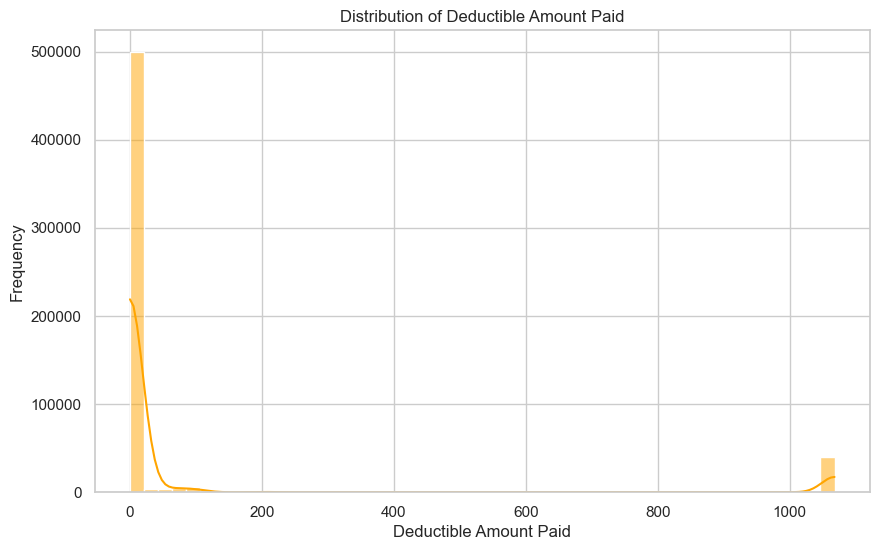

In [57]:
# Visualize Deductible Amount Paid Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_merged['DeductibleAmtPaid'], bins=50, kde=True , color='orange')
plt.xlabel('Deductible Amount Paid')
plt.ylabel('Frequency')
plt.title('Distribution of Deductible Amount Paid')
plt.show()

<Figure size 1200x600 with 0 Axes>

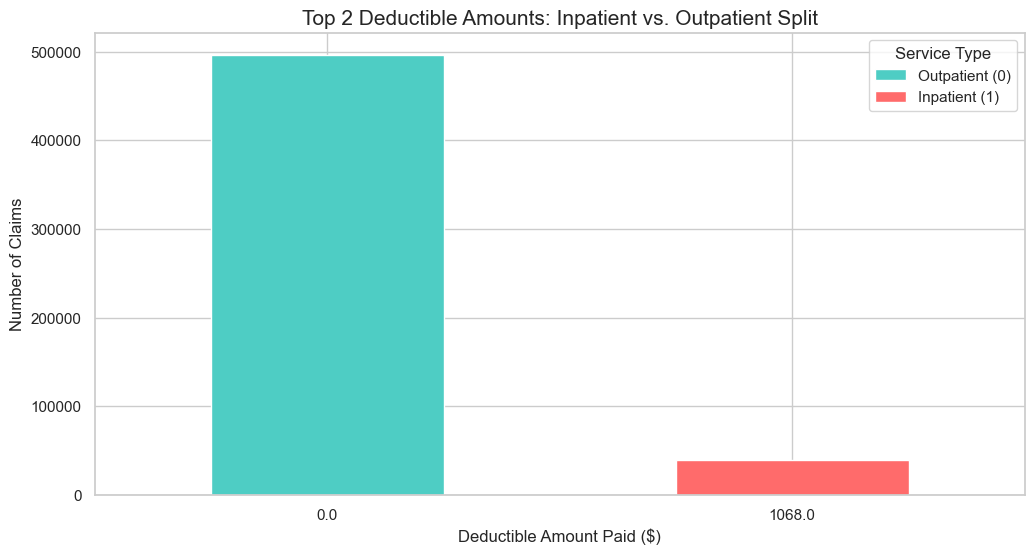

In [58]:
# Visualization: Top 2 Deductible Amounts by Patient Type

# Identify the Top 2 most common Deductible Amounts
top_2_deductibles = train_merged['DeductibleAmtPaid'].value_counts().head(2).index

# Filter the dataset to only these top 2 values
subset_df = train_merged[train_merged['DeductibleAmtPaid'].isin(top_2_deductibles)]

# Prepare Data for Plotting (Count of claims per Deductible + Inpatient Status)
plot_data = subset_df.groupby(['DeductibleAmtPaid', 'IsInpatient']).size().unstack(fill_value=0)

# Create the Stacked Bar Chart
plt.figure(figsize=(12, 6))
plot_data.plot(kind='bar', stacked=True, color=['#4ecdc4', '#ff6b6b'], figsize=(12, 6))

plt.title('Top 2 Deductible Amounts: Inpatient vs. Outpatient Split', fontsize=15)
plt.xlabel('Deductible Amount Paid ($)', fontsize=12)
plt.ylabel('Number of Claims', fontsize=12)
plt.legend(['Outpatient (0)', 'Inpatient (1)'], title='Service Type')
plt.xticks(rotation=0)
plt.show()

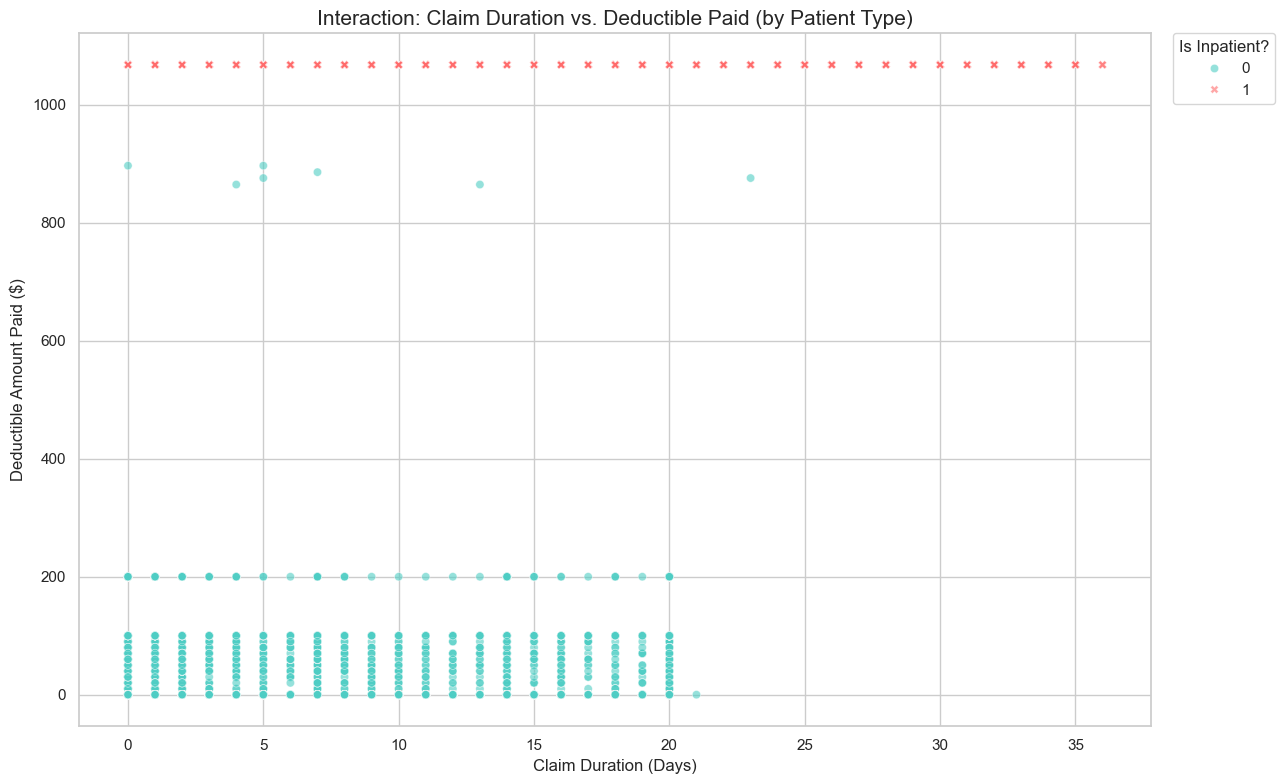

In [59]:
# Visualization: 3-Variable Interaction
# (Claim Duration, Deductible Paid, Patient Type)

plt.figure(figsize=(13, 8))

sns.scatterplot(
    data=train_merged,
    x='ClaimDurationDays',
    y='DeductibleAmtPaid',
    hue='IsInpatient',
    style='IsInpatient',   # Adds shape difference for extra clarity
    palette={0: '#4ecdc4', 1: '#ff6b6b'}, # Teal for Outpatient, Red for Inpatient
    alpha=0.6              # Transparency to see overlapping points
)

plt.title('Interaction: Claim Duration vs. Deductible Paid (by Patient Type)', fontsize=15)
plt.xlabel('Claim Duration (Days)', fontsize=12)
plt.ylabel('Deductible Amount Paid ($)', fontsize=12)
plt.legend(title='Is Inpatient?', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

### Data Cleaning: Conditional Imputation for DeductibleAmtPaid

Based on the patterns observed, we will impute missing DeductibleAmtPaid values using the IsInpatient flag to assign standard deductible amounts

In [60]:
# (Domain Knowledge)
# Inpatient (1)  -> Standard Deductible is $1068
# Outpatient (0) -> Standard Deductible is $0
impute_map = {1: 1068,0: 0 }

# We create a Series of "Correct Values" based on IsInpatient, then use it to fill NaNs
train_merged['DeductibleAmtPaid'] = train_merged['DeductibleAmtPaid'].fillna(
    train_merged['IsInpatient'].map(impute_map)
)

print(f"Missing Deductibles in Train: {train_merged['DeductibleAmtPaid'].isnull().sum()}")

train_merged['DeductibleAmtPaid'].value_counts(dropna=False)

Missing Deductibles in Train: 0


DeductibleAmtPaid
0.0       496701
1068.0     40474
100.0       4582
70.0        2420
60.0        2065
40.0        2045
80.0        2024
50.0        1969
20.0        1406
30.0        1336
90.0        1245
10.0        1203
200.0        734
876.0          2
897.0          2
865.0          2
886.0          1
Name: count, dtype: int64

In [61]:
train_merged['DeductibleAmtPaid'] = train_merged['DeductibleAmtPaid'].astype('int64')

## Diagnosis and Procedure Code

Since the values used for the 16 columns ```ClmAdmitDiagnosisCode``` , ```ClmDiagnosisCode```(1-10) and ```ClmProcedureCode```(1-5) are Numerical codes and our earliest date value in all columns is 31st of December 2009 and according to project description the data source is the  U.S. Centers for Medicare & Medicaid Services (CMS), I did my research and found out that the data was encoded by International Classification of Diseases (ICD) following ICD-9-CM Diagnosis and Procedure Code system version 28 (2010 October version).

which can be found at :

https://www.cms.gov/medicare/coding-billing/icd-10-codes/icd-9-cm-diagnosis-procedure-codes-abbreviated-and-full-code-titles

and downloaded from the following link as a zip file contains 6 txt & xls files :
 https://www.cms.gov/medicare/coding/icd9providerdiagnosticcodes/downloads/cmsv28_master_descriptions.zip

The DX files contain the codes for Diseases and Conditions (used in ClmDiagnosisCode_1 to ClmDiagnosisCode_10):
- 'CMS28_DESC_LONG_SHORT_DX.xls' : both long & short descriptions for diseases codes
- 'CMS28_DESC_LONG_DX.txt' : long descriptions only for diseases codes
- 'CMS28_DESC_SHORT_DX.txt' : short descriptions only for diseases codes

The SG files contain the codes for Surgical/Procedure (used in ClmProcedureCode_1 to ClmProcedureCode_5):
- 'CMS28_DESC_LONG_SHORT_SG.xls' : both long & short descriptions for procedure codes
- 'CMS28_DESC_LONG_SG.txt' : long descriptions only for procedure codes
- 'CMS28_DESC_SHORT_SG.txt' : short descriptions only for procedure codes

for our context , we will use the **long description** files

in the docs folder i added the documents which we refer to in all the project , In the next cell i explain what we did fully to handle those 16 columns and group every single value in them into 17 different groups , I will add the code we used for that cell below

In [62]:
# Global Lookups for CMS Files
cms_dx_lookup = {}
cms_sg_lookup = {}


def load_cms_files():
    """Loads CMS description files into global dictionaries."""
    global cms_dx_lookup, cms_sg_lookup

    # Paths to the CMS files (Adjust these paths if your folder structure is different)
    dx_path = '../docs/CMSv28_Descriptions/CMS28_DESC_LONG_DX.txt'
    sg_path = '../docs/CMSv28_Descriptions/CMS28_DESC_LONG_SG.txt'

    def load_file(path):
        lookup = {}
        if os.path.exists(path):
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    # CMS Format is typically: CODE   DESCRIPTION
                    parts = line.strip().split(maxsplit=1)
                    if len(parts) == 2:
                        code, desc = parts
                        lookup[code] = desc
        else:
            print(f"Warning: CMS file not found at {path}")
        return lookup

    print("Loading CMS Diagnosis definitions...")
    cms_dx_lookup = load_file(dx_path)

    print("Loading CMS Procedure definitions...")
    cms_sg_lookup = load_file(sg_path)


def lookup_with_format(code_str, is_diagnosis):
    """Helper to look up code in icd9cms library with different formats."""
    # Try exact match first
    desc = icd9.search(code_str)
    if desc:
        return desc.short_desc if desc.short_desc else desc.long_desc

    # Try adding decimal based on type
    if is_diagnosis:
        if len(code_str) > 3:
            code_with_dot = code_str[:3] + '.' + code_str[3:]
            desc = icd9.search(code_with_dot)
            if desc:
                return desc.short_desc if desc.short_desc else desc.long_desc
    else:
        if len(code_str) > 2:
            code_with_dot = code_str[:2] + '.' + code_str[2:]
            desc = icd9.search(code_with_dot)
            if desc:
                return desc.short_desc if desc.short_desc else desc.long_desc
    return None


def get_description(code, is_diagnosis=True):
    """Retrieves description for a code using CMS files, Manual list, or Library."""
    if pd.isna(code) or code == '':
        return "Unknown/Missing"

    code_str = str(code).strip()
    if code_str.endswith('.0'):
        code_str = code_str[:-2]

    # Manual overrides
    MANUAL_CODES = {
        '9904': 'Transfusion of packed cells',
        '8154': 'Total knee replacement',
        '66': 'Operations on fallopian tubes',
        '660': 'Salpingotomy and salpingostomy',
        '3893': 'Venous catheterization, NEC',
        '3995': 'Hemodialysis',
        '4516': 'EGD with closed biopsy',
        '4513': 'Other endoscopy of small intestine',
        '5123': 'Laparoscopic cholecystectomy',
        '8152': 'Partial hip replacement',
        '9339': 'Other physical therapy',
        '8108': 'Lumbar/lumbosacral fusion, post',
        '4523': 'Colonoscopy',
        '4525': 'Closed biopsy of large intestine',
        '5491': 'Percutaneous abdominal drainage',
        '4311': 'Percutaneous gastrostomy',
        '3324': 'Closed biopsy of bronchus',
        '8102': 'Other cervical fusion, ant',
        '3895': 'Venous cath for renal dialysis',
        '4573': 'Open/other right hemicolectomy',
        '8659': 'Closure of skin/subcut tissue NEC',
        '4019': 'Hypertension NOS',
        '2724': 'Hyperlipidemia NEC/NOS',
        '25000': 'DMII wo cmp nt st uncntr',
        '42731': 'Atrial fibrillation',
        '53081': 'Esophageal reflux',
        '2449': 'Hypothyroidism NOS',
        '2720': 'Pure hypercholesterolemia',
        '4011': 'Benign hypertension',
        '2859': 'Anemia NOS',
        '25001': 'DMI wo cmp nt st uncntr',
        '0431': 'Intracerebral hemorrhage',
        '51': 'Operations on gallbladder and biliary tract',
        '0430': 'Subarachnoid hemorrhage',
        '80': 'Incision and excision of joint structures',
        '70': 'Operations on vagina and cul-de-sac',
        '61': 'Operations on scrotum and tunica vaginalis',
        '17': 'Other miscellaneous diagnostic and therapeutic procedures',
        '81': 'Repair and plastic operations on joint structures',
        '64': 'Operations on penis',
        '82': 'Operations on muscle, tendon, and fascia of hand',
        '84': 'Other procedures on musculoskeletal system',
        '113': 'Excision of pterygium',
        '22': 'Operations on nasal sinuses',
        '50': 'Operations on liver',
        '71': 'Operations on vulva and perineum',
        '62': 'Operations on testes',
        '73': 'Other procedures inducing or assisting delivery',
        '72': 'Forceps, vacuum, and breech delivery',
        '42': 'Operations on esophagus',
        '13': 'Operations on lens',
        '14': 'Operations on retina, choroid, vitreous, and posterior chamber',
        '54': 'Other operations on abdominal region',
        '90': 'Microscopic examination - I',
        '34': 'Operations on chest wall, pleura, mediastinum, and diaphragm',
        '36': 'Operations on vessels of heart',
        '83': 'Operations on muscle, tendon, fascia, and bursa, except hand',
        '40': 'Operations on lymphatic system',
        '59': 'Other operations on urinary system',
        '609': 'Other operations on prostate',
        '15': 'Operations on extraocular muscles',
        '11': 'Operations on cornea',
        '407': 'Other excision or avulsion of cranial and peripheral nerves',
        '889': 'Other diagnostic imaging',
        '52': 'Operations on pancreas',
        '16': 'Operations on orbit and eyeball',
        '419': 'Other operations on spleen and bone marrow',
        '43': 'Incision and excision of stomach',
        '53': 'Repair of hernia'
    }

    if code_str in MANUAL_CODES:
        return MANUAL_CODES[code_str]

    if is_diagnosis:
        if code_str in cms_dx_lookup: return cms_dx_lookup[code_str]
    else:
        if code_str in cms_sg_lookup: return cms_sg_lookup[code_str]

    if code_str in cms_dx_lookup: return cms_dx_lookup[code_str]
    if code_str in cms_sg_lookup: return cms_sg_lookup[code_str]

    desc = lookup_with_format(code_str, is_diagnosis)
    if desc: return desc

    desc = lookup_with_format(code_str, not is_diagnosis)
    if desc: return desc

    return "Description not found"


# Grouping Functions

def get_diagnosis_group(code):
    code = str(code).strip().upper()

    if code.startswith('V'): return 'Supplementary Factors (V-Codes)'
    if code.startswith('E'): return 'External Causes of Injury (E-Codes)'

    try:
        prefix_str = code[:3]
        if not prefix_str: return 'Other/Unknown Diagnosis'
        prefix = int(prefix_str)

        if 1 <= prefix <= 139: return 'Infectious And Parasitic Diseases'
        if 140 <= prefix <= 239: return 'Neoplasms'
        if 240 <= prefix <= 279: return 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'
        if 280 <= prefix <= 289: return 'Diseases Of The Blood And Blood-Forming Organs'
        if 290 <= prefix <= 319: return 'Mental Disorders'
        if 320 <= prefix <= 389: return 'Diseases Of The Nervous System And Sense Organs'
        if 390 <= prefix <= 459: return 'Diseases Of The Circulatory System'
        if 460 <= prefix <= 519: return 'Diseases Of The Respiratory System'
        if 520 <= prefix <= 579: return 'Diseases Of The Digestive System'
        if 580 <= prefix <= 629: return 'Diseases Of The Genitourinary System'
        if 630 <= prefix <= 679: return 'Complications Of Pregnancy, Childbirth, And The Puerperium'
        if 680 <= prefix <= 709: return 'Diseases Of The Skin And Subcutaneous Tissue'
        if 710 <= prefix <= 739: return 'Diseases Of The Musculoskeletal System And Connective Tissue'
        if 740 <= prefix <= 759: return 'Congenital Anomalies'
        if 760 <= prefix <= 779: return 'Certain Conditions Originating In The Perinatal Period'
        if 780 <= prefix <= 799: return 'Symptoms, Signs, And Ill-Defined Conditions'
        if 800 <= prefix <= 999: return 'Injury And Poisoning'

        return 'Other/Unknown Diagnosis'
    except:
        return 'Other/Unknown Diagnosis'


def get_procedure_group(code):
    code = str(code).strip()

    try:
        if not code: return 'Other/Unknown Procedure'
        if len(code) == 1:
            prefix = int(code)
        else:
            prefix = int(code[:2])

        if prefix == 0: return 'Procedures and interventions, Not Elsewhere Classified'
        if 1 <= prefix <= 5: return 'Operations on the nervous system'
        if 6 <= prefix <= 7: return 'Operations on the endocrine system'
        if 8 <= prefix <= 16: return 'Operations on the eye'
        if prefix == 17: return 'Other miscellaneous diagnostic and therapeutic procedures'
        if 18 <= prefix <= 20: return 'Operations on the ear'
        if 21 <= prefix <= 29: return 'Operations on the nose, mouth, and pharynx'
        if 30 <= prefix <= 34: return 'Operations on the respiratory system'
        if 35 <= prefix <= 39: return 'Operations on the cardiovascular system'
        if 40 <= prefix <= 41: return 'Operations on the hemic and lymphatic system'
        if 42 <= prefix <= 54: return 'Operations on the digestive system'
        if 55 <= prefix <= 59: return 'Operations on the urinary system'
        if 60 <= prefix <= 64: return 'Operations on the male genital organs'
        if 65 <= prefix <= 71: return 'Operations on the female genital organs'
        if 72 <= prefix <= 75: return 'Obstetrical procedures'
        if 76 <= prefix <= 84: return 'Operations on the musculoskeletal system'
        if 85 <= prefix <= 86: return 'Operations on the integumentary system'
        if 87 <= prefix <= 99: return 'Miscellaneous diagnostic and therapeutic procedures'

        return 'Other/Unknown Procedure'
    except:
        return 'Other/Unknown Procedure'


def get_larger_group(group_name):
    """Maps the detailed Group to a Larger Optimized Group."""
    group_name = str(group_name)

    # Consolidate all Procedures/Operations
    if ('Operation' in group_name or 'Procedure' in group_name
            or 'Miscellaneous' in group_name or 'procedures' in group_name):
        return 'Procedures & Surgeries'

    # Consolidate Trauma (Injury + External Causes)
    if 'Injury' in group_name or 'External Causes' in group_name:
        return 'Injury, Poisoning & External Causes'

    # Consolidate Obstetrics (Pregnancy + Perinatal)
    if 'Pregnancy' in group_name or 'Perinatal' in group_name:
        return 'Pregnancy, Childbirth & Perinatal'

    # Consolidate Systemic issues (Endocrine + Blood)
    if 'Blood' in group_name or 'Endocrine' in group_name or 'Immunity' in group_name:
        return 'Systemic, Metabolic & Blood Disorders'

    # Shorten/Clean names for others
    if 'Nervous' in group_name: return 'Diseases Of The Nervous System'
    if 'Musculoskeletal' in group_name: return 'Musculoskeletal & Connective Tissue'
    if 'Skin' in group_name: return 'Diseases Of The Skin'
    if 'Symptoms' in group_name: return 'Symptoms, Signs, And Ill-Defined'

    # Return original if no change needed (Circulatory, Respiratory, etc.)
    return group_name


# Main Processing

def process_files():
    load_cms_files()

    inpatient_path = '../data/Train_Inpatientdata.csv'
    outpatient_path = '../data/Train_Outpatientdata.csv'

    print("Loading Data...")

    all_dfs = []
    for path in [inpatient_path, outpatient_path]:
        try:
            if os.path.exists(path):
                print(f"Reading {path}...")
                all_dfs.append(pd.read_csv(path))
            else:
                print(f"Skipping {path} (not found)")
        except Exception as e:
            print(f"Error reading {path}: {e}")

    if not all_dfs:
        print("No data loaded. Exiting.")
        return

    df = pd.concat(all_dfs, ignore_index=True)

    diag_cols = ['ClmAdmitDiagnosisCode'] + [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]
    proc_cols = [f'ClmProcedureCode_{i}' for i in range(1, 7)]

    all_codes = {}

    # Helper to process columns
    def process_cols(cols, is_diag):
        for col in cols:
            if col not in df.columns: continue
            vc = df[col].value_counts().to_dict()
            for code, count in vc.items():
                code_str = str(code).strip()
                if code_str.endswith('.0'): code_str = code_str[:-2]

                if code_str not in all_codes:
                    desc = get_description(code_str, is_diagnosis=is_diag)
                    group = get_diagnosis_group(code_str) if is_diag else get_procedure_group(code_str)
                    larger_group = get_larger_group(group)

                    all_codes[code_str] = {
                        'code': code_str,
                        'type': 'Diagnosis' if is_diag else 'Procedure',
                        'count': count,
                        'description': desc,
                        'Group': group,
                        'Larger group': larger_group
                    }
                else:
                    all_codes[code_str]['count'] += count

    print("Processing Codes...")
    process_cols(diag_cols, is_diag=True)
    process_cols(proc_cols, is_diag=False)

    # Convert to DataFrame
    results_df = pd.DataFrame(all_codes.values())

    # Sort by count descending
    results_df = results_df.sort_values('count', ascending=False)

    # Save to CSV
    output_path = '../docs/code_definitions_grouped.csv'
    results_df.to_csv(output_path, index=False)
    print(f"Saved all grouped code definitions to {output_path}")
    print("\nAll Larger Groups:")
    print(results_df['Larger group'].value_counts())
    print("\nTotal Frequency Count by Larger Group (Total Occurrences):")
    total_counts = results_df.groupby('Larger group')['count'].sum().sort_values(ascending=False)
    print(total_counts)

if __name__ == "__main__":
    process_files()

Loading CMS Diagnosis definitions...
Loading CMS Procedure definitions...
Loading Data...
Reading ../data/Train_Inpatientdata.csv...
Reading ../data/Train_Outpatientdata.csv...
Processing Codes...
Saved all grouped code definitions to ../docs/code_definitions_grouped.csv

All Larger Groups:
Larger group
Injury, Poisoning & External Causes      2478
Diseases Of The Nervous System           1349
Supplementary Factors (V-Codes)           963
Neoplasms                                 919
Musculoskeletal & Connective Tissue       883
Procedures & Surgeries                    779
Infectious And Parasitic Diseases         746
Diseases Of The Digestive System          578
Mental Disorders                          467
Diseases Of The Circulatory System        453
Systemic, Metabolic & Blood Disorders     436
Diseases Of The Genitourinary System      378
Symptoms, Signs, And Ill-Defined          345
Congenital Anomalies                      340
Pregnancy, Childbirth & Perinatal         279
Disea

In [63]:
# Define the columns you want to pool together
proc_cols = [ 'ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10'
]

# Stack them into one single Series and count
# stack() automatically drops NaN values, which is exactly what you want here.
distinct_counts = train_merged[proc_cols].stack().value_counts().head(10)

# View the top 10 most common codes across all 10 columns
print(distinct_counts)

4019     77056
25000    37356
2724     35763
V5869    24904
4011     23773
42731    20138
V5861    20001
2720     18268
2449     17600
4280     15507
Name: count, dtype: int64


In [64]:
# Define the columns you want to pool together
proc_cols = [
    'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
    'ClmProcedureCode_4', 'ClmProcedureCode_5'
]

# Stack them into one single Series and count
# stack() automatically drops NaN values, which is exactly what you want here.
distinct_counts = train_merged[proc_cols].stack().value_counts().head(10)

# View the top 10 most common codes across all 5 columns
print(distinct_counts)

4019.0    1959
9904.0    1152
2724.0    1054
8154.0    1022
66.0       901
3893.0     854
3995.0     809
4516.0     651
3722.0     589
8151.0     463
Name: count, dtype: int64


### Feature Engineering & Dimensionality Reduction

In this step, we performed advanced **Feature Engineering** to transform raw medical codes into meaningful numerical features for our model.

#### 1. Feature Construction (Usage Intensity)
We created two new features, `ClmDiagnosisCount` and `ClmProceduresCount`, which calculate the **non-null count** of diagnoses and procedures per claim.
* **Why?** This acts as a proxy for **patient complexity**. A patient with 10 diagnoses is likely sicker and higher-risk than a patient with only 1.

#### 2. Dimensionality Reduction (Grouping)
The raw dataset contained thousands of unique ICD-9 codes. Using them directly would create a sparse dataset with too much noise ("Curse of Dimensionality").
* **What we did:** We mapped thousands of granular codes into **17 high-level clinical "Super Groups"** (e.g., *Circulatory*, *Trauma*, *Procedures*).
* **Why?** This reduces noise and helps the model find patterns (e.g., "Patients with *any* heart issue are higher risk") rather than getting lost in specific, rare codes.

#### 3. Frequency Encoding (Bag-of-Words Approach)
For the 17 new group columns (e.g., `Count_Circulatory`), we counted how many times a code from that group appeared across all 16 diagnosis/procedure columns for that patient.
* **Why?** Unlike standard One-Hot Encoding (0 or 1), this captures **severity**. A patient with 3 separate heart diagnoses is different from a patient with just 1.

#### 4. Feature Abstraction
We replaced the specific `ClmAdmitDiagnosisCode` (e.g., `401.9`) with its broader category (e.g., `Diseases Of The Circulatory System`).
* **Why?** This allows the model to treat similar admission reasons (like different types of heart attacks) as a single meaningful category.

In [65]:
df_defs = pd.read_csv('../docs/code_definitions_grouped.csv')

code_to_group = dict(zip(df_defs['code'].astype(str), df_defs['Larger group']))

diag_cols_1_10 = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]
proc_cols_1_5 = [f'ClmProcedureCode_{i}' for i in range(1, 6)]

# The 16 columns you specified for group counting
all_code_cols = ['ClmAdmitDiagnosisCode'] + diag_cols_1_10 + proc_cols_1_5

In [66]:
# Count non-null values for diagnoses (1-10) and procedures (1-5)
train_merged['ClmDiagnosisCount'] = train_merged[diag_cols_1_10].notnull().sum(axis=1)
train_merged['ClmProceduresCount'] = train_merged[proc_cols_1_5].notnull().sum(axis=1)

In [67]:
train_merged.head()

BeneID   ClaimID  Provider  InscClaimAmtReimbursed AttendingPhysician  \
0  BENE11001  CLM46614  PRV55912                   26000          PHY390922   
1  BENE11001  CLM66048  PRV55907                    5000          PHY318495   
2  BENE11001  CLM68358  PRV56046                    5000          PHY372395   
3  BENE11011  CLM38412  PRV52405                    5000          PHY369659   
4  BENE11014  CLM63689  PRV56614                   10000          PHY379376   

  OperatingPhysician OtherPhysician ClmAdmitDiagnosisCode  DeductibleAmtPaid  \
0                NaN            NaN                  7866               1068   
1          PHY318495            NaN                  6186               1068   
2                NaN      PHY324689                 29590               1068   
3          PHY392961      PHY349768                   431               1068   
4          PHY398258            NaN                 78321               1068   

  DiagnosisGroupCode ClmDiagnosisCode_1 ClmDiagnosisCode_2 ClmDiagnosisCode_3  \
0                201               1970               4019               5853   
1                750               6186               2948              56400   
2                883              29623              30390              71690   
3                067              43491               2762               7843   
4                975                042               3051              34400   

  ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6 ClmDiagnosisCode_7  \
0               7843               2768              71590               2724   
1                NaN                NaN                NaN                NaN   
2              34590              V1581              32723                NaN   
3              32723              V1041               4254              25062   
4               5856              42732                486               5119   

  ClmDiagnosisCode_8 ClmDiagnosisCode_9 ClmDiagnosisCode_10  \
0              19889               5849                 NaN   
1                NaN                NaN                 NaN   
2                NaN                NaN                 NaN   
3              40390               4019                 NaN   
4              29620              20300                 NaN   

   ClmProcedureCode_1  ClmProcedureCode_2  ClmProcedureCode_3  \
0                 NaN                 NaN                 NaN   
1              7092.0                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3               331.0                 NaN                 NaN   
4              3893.0                 NaN                 NaN   

   ClmProcedureCode_4  ClmProcedureCode_5  Gender  Race RenalDiseaseIndicator  \
0                 NaN                 NaN       1     1                     0   
1                 NaN                 NaN       1     1                     0   
2                 NaN                 NaN       1     1                     0   
3                 NaN                 NaN       2     2                     0   
4                 NaN                 NaN       2     1                     Y   

   State  County  NoOfMonths_PartACov  NoOfMonths_PartBCov  \
0     39     230                   12                   12   
1     39     230                   12                   12   
2     39     230                   12                   12   
3      1     360                   12                   12   
4     45     780                   12                   12   

   ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease  \
0                      1                         2                          1   
1                      1                         2                          1   
2                      1                         2                          1   
3                      2                         1                          1   
4                      2                 

In [68]:
# Feature Engineering: Grouped Counts (The 17 Columns)
print("Processing Group Counts...")

# Step A: Create a temporary "long" version of the data to map and count efficiently
# We work with a subset to save memory, using the index to map back to the original df
temp_df = train_merged[all_code_cols].copy()
temp_df['TEMP_INDEX'] = temp_df.index

# Melt: Turns the 16 columns into 2 columns: [Index, Code]
melted = temp_df.melt(id_vars='TEMP_INDEX', value_vars=all_code_cols, value_name='Code').dropna(subset=['Code'])

# Clean codes (ensure string, remove decimals if any exist to match your dictionary)
melted['Code'] = melted['Code'].astype(str).str.replace('.', '', regex=False)

# Step B: Map the Codes to "Larger group"
melted['Group'] = melted['Code'].map(code_to_group)

# Fill unmapped codes with 'Unknown' (Optional, helps verify data quality)
melted['Group'] = melted['Group'].fillna('UnknownCodesCount')

# Step C: Count occurrences of each Group per row (Pivot Table)
# This creates columns for each group with the count of times it appeared in that row
group_counts = pd.crosstab(melted['TEMP_INDEX'], melted['Group'])

# Step D: Join this back to the main dataframe
# We align on the index.
train_merged = train_merged.join(group_counts)

new_group_cols = group_counts.columns
train_merged[new_group_cols] = train_merged[new_group_cols].fillna(0)

# Ensure we only keep the 17 specific groups you asked for (plus Unknown if you want it)
expected_groups = [
    'Injury, Poisoning & External Causes',
    'Diseases Of The Nervous System',
    'Supplementary Factors (V-Codes)',
    'Neoplasms',
    'Musculoskeletal & Connective Tissue',
    'Procedures & Surgeries',
    'Infectious And Parasitic Diseases',
    'Diseases Of The Digestive System',
    'Mental Disorders',
    'Diseases Of The Circulatory System',
    'Systemic, Metabolic & Blood Disorders',
    'Diseases Of The Genitourinary System',
    'Congenital Anomalies',
    'Symptoms, Signs, And Ill-Defined',
    'Pregnancy, Childbirth & Perinatal',
    'Diseases Of The Respiratory System',
    'Diseases Of The Skin'
]

# Double check that columns are int type (crosstab/join might create floats)
for col in expected_groups:
    if col in train_merged.columns:
        train_merged[col] = train_merged[col].astype(int)
    else:
        # If a group didn't appear in this specific dataset, create it as 0
        train_merged[col] = 0

Processing Group Counts...


In [69]:
print(train_merged[['ClmDiagnosisCount', 'ClmProceduresCount'] + expected_groups[:3]].head())

   ClmDiagnosisCount  ClmProceduresCount  Injury, Poisoning & External Causes  \
0                  9                   0                                    0   
1                  3                   1                                    0   
2                  6                   0                                    0   
3                  9                   1                                    0   
4                  9                   1                                    0   

   Diseases Of The Nervous System  Supplementary Factors (V-Codes)  
0                               0                                0  
1                               0                                0  
2                               2                                1  
3                               2                                1  
4                               1                                0  


In [70]:
train_merged['ClmAdmitDiagnosisCode'].value_counts(dropna=False).head()

ClmAdmitDiagnosisCode
NaN      412312
V7612      4074
42731      3634
78605      2992
4019       2732
Name: count, dtype: int64

In [71]:
# Update ClmAdmitDiagnosisCode
# Map the code to the group name, filling NaN with 'Unknown'
print("Updating Admit Diagnosis...")
train_merged['ClmAdmitDiagnosisCode'] = train_merged['ClmAdmitDiagnosisCode'].astype(str).str.replace('.', '', regex=False)
train_merged['ClmAdmitDiagnosisCode'] = train_merged['ClmAdmitDiagnosisCode'].map(code_to_group).fillna('Unknown')

# Display results
print(train_merged['ClmAdmitDiagnosisCode'].value_counts(dropna=False).head())

Updating Admit Diagnosis...
ClmAdmitDiagnosisCode
Unknown                                412312
Symptoms, Signs, And Ill-Defined        31973
Supplementary Factors (V-Codes)         19982
Diseases Of The Circulatory System      19579
Musculoskeletal & Connective Tissue     15955
Name: count, dtype: int64


In [72]:
train_merged['UnknownCodesCount'] = train_merged['UnknownCodesCount'].astype('int64')

In [73]:
# Drop the used 15 column , they now have no meaning after extracting their features
cols_to_drop = diag_cols_1_10 + proc_cols_1_5
train_merged.drop(columns=cols_to_drop, inplace=True, axis=1)
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 58 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   BeneID                                 558211 non-null  object 
 1   ClaimID                                558211 non-null  object 
 2   Provider                               558211 non-null  object 
 3   InscClaimAmtReimbursed                 558211 non-null  int64  
 4   AttendingPhysician                     556703 non-null  object 
 5   OperatingPhysician                     114447 non-null  object 
 6   OtherPhysician                         199736 non-null  object 
 7   ClmAdmitDiagnosisCode                  558211 non-null  object 
 8   DeductibleAmtPaid                      558211 non-null  int64  
 9   DiagnosisGroupCode                     558211 non-null  object 
 10  Gender                                 558211 non-null  

## Gender

In [74]:
train_merged['Gender'].value_counts(dropna=False)

Gender
2    323114
1    235097
Name: count, dtype: int64

### Data Transformation : Codes to Letter

after doing my research , I found that according to CMS Linkable 2008–2010 Medicare Data Entrepreneurs’ Synthetic Public Use File (DE-SynPUF) :

https://www.cms.gov/files/document/de-10-codebook.pdf-0

In page 17 it was mentioned that :

- Label Male was Coded to '1'
- Label Female was Coded to '2'

In [75]:
train_merged['Gender'] = train_merged['Gender'].replace(2,0)

In [76]:
train_merged['Gender'].value_counts(dropna=False)

Gender
0    323114
1    235097
Name: count, dtype: int64

In [77]:
# for better aggregation and data understanding , we will rename this column to IsMale
train_merged.rename(columns={'Gender': 'IsMale'} ,inplace=True)

## Race

In [78]:
train_merged['Race'].value_counts(dropna=False)

Race
1    471036
2     55640
3     19715
5     11820
Name: count, dtype: int64

### Data Transformation : Codes to Labels

after doing my research , I found that according to CMS Linkable 2008–2010 Medicare Data Entrepreneurs’ Synthetic Public Use File (DE-SynPUF) :

https://www.cms.gov/files/document/de-10-codebook.pdf-0

In page 18 it was mentioned that :
- Label White was Coded to '1'
- Label Black was Coded to '2'
- Label Hispanic was Coded to '5'
- Label Others was Coded to '3'

Where : Others = UNKNOWN, OTHER, ASIAN, HISPANIC, NORTH AMERICAN NATIVE

In [79]:
train_merged['Race'] = train_merged['Race'].map(
    { 1 : 'White', 2:'Black',3:'Others', 5:'Hispanic'} )

In [80]:
train_merged['Race'].value_counts(dropna=False)

Race
White       471036
Black        55640
Others       19715
Hispanic     11820
Name: count, dtype: int64

In [81]:
# for better aggregation in next step , we translate each one to a boolean column
race_mapping = {
    'White': 'IsWhiteRace',
    'Black': 'IsBlackRace',
    'Hispanic': 'IsHispanicRace',
    'Others': 'IsOtherRace'
}

# Loop through the map to create the columns
for race_val, new_col_name in race_mapping.items():
    train_merged[new_col_name] = (train_merged['Race'] == race_val).astype(int)

# Check the result
print(train_merged[['Race', 'IsWhiteRace', 'IsBlackRace', 'IsHispanicRace', 'IsOtherRace']].head())
# Check the result

    Race  IsWhiteRace  IsBlackRace  IsHispanicRace  IsOtherRace
0  White            1            0               0            0
1  White            1            0               0            0
2  White            1            0               0            0
3  Black            0            1               0            0
4  White            1            0               0            0


In [82]:
# Drop original race column now as its redundant
train_merged.drop(columns=['Race'], inplace=True,axis=1)

## RenalDiseaseIndicator

The beneficiary has ESRD (end-stage renal disease) AKA Kidney/Renal Failure or not

In [83]:
train_merged['RenalDiseaseIndicator'].value_counts(dropna=False)

RenalDiseaseIndicator
0    448363
Y    109848
Name: count, dtype: int64

#### Data Cleaning: Y -> 1

In [84]:
train_merged['RenalDiseaseIndicator'] = train_merged['RenalDiseaseIndicator'].map({'Y': 1}).fillna(0).astype(int)

In [85]:
train_merged['RenalDiseaseIndicator'].value_counts(dropna=False)

RenalDiseaseIndicator
0    448363
1    109848
Name: count, dtype: int64

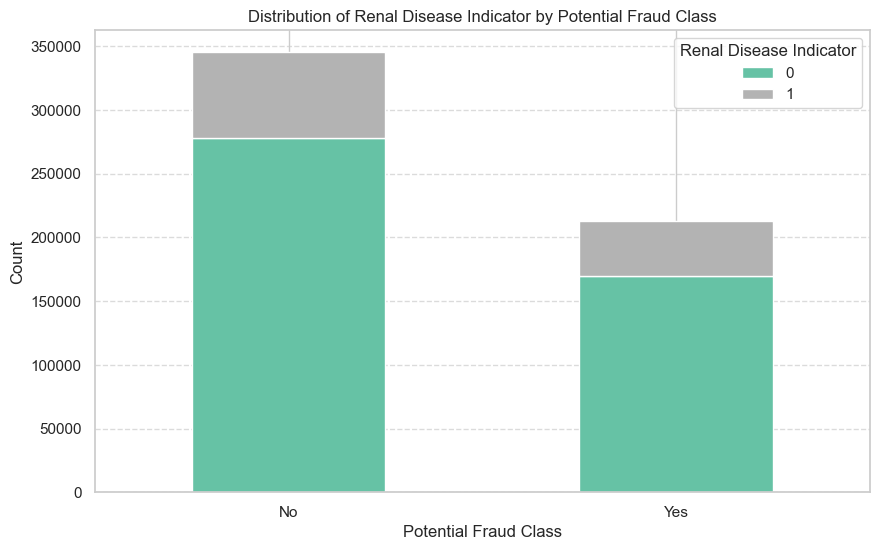

In [86]:
# Create a cross-tabulation of the two columns
counts = pd.crosstab(train_merged['PotentialFraud'], train_merged['RenalDiseaseIndicator'])

# Plot the stacked bar chart
ax = counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')

# Customizing the chart
plt.title('Distribution of Renal Disease Indicator by Potential Fraud Class')
plt.xlabel('Potential Fraud Class')
plt.ylabel('Count')
plt.legend(title='Renal Disease Indicator')
plt.xticks(rotation=0)  # Keeps the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a subtle grid for readability

plt.show()

In [87]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 61 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   BeneID                                 558211 non-null  object 
 1   ClaimID                                558211 non-null  object 
 2   Provider                               558211 non-null  object 
 3   InscClaimAmtReimbursed                 558211 non-null  int64  
 4   AttendingPhysician                     556703 non-null  object 
 5   OperatingPhysician                     114447 non-null  object 
 6   OtherPhysician                         199736 non-null  object 
 7   ClmAdmitDiagnosisCode                  558211 non-null  object 
 8   DeductibleAmtPaid                      558211 non-null  int64  
 9   DiagnosisGroupCode                     558211 non-null  object 
 10  IsMale                                 558211 non-null  

## State

In [88]:
train_merged['State'].value_counts(dropna=False)

State
5     51350
10    39073
33    35024
45    34022
14    24417
39    24251
23    21343
36    21291
34    18905
11    17003
31    15940
49    14997
44    14418
15    14213
22    13624
26    12911
50    11740
21    11261
42    10491
18    10322
1     10240
52     9792
3      9344
19     7917
24     7726
4      7571
16     7457
6      7200
37     6990
25     6682
7      5617
38     5518
17     4884
51     4644
54     4233
28     4168
20     3833
32     3456
46     3381
13     2765
30     2654
43     2002
27     1995
29     1978
47     1827
12     1706
8      1530
41     1110
53     1098
35      940
2       738
9       619
Name: count, dtype: int64

### Data Transformation : Numerical codes to Abbreviations

We have state codes between 1 and 54 , with 40 and 48 missing

after doing my research , the CMS used the Social Security Administration (SSA) Geographic Codes , where its mentioned here :

https://www.cms.gov/Regulations-and-Guidance/Guidance/Transmittals/downloads/R62SOMA.pdf

According to that pdf :

| Code | State                 | Code | State                 | Code | State               |
|-----|------------------------|------|------------------------|------|---------------------|
| 01  | Alabama               | 02   | Alaska                | 03   | Arizona             |
| 04  | Arkansas              | 05   | California            | 06   | Colorado            |
| 07  | Connecticut           | 08   | Delaware              | 09   | District of Columbia |
| 10  | Florida               | 11   | Georgia               | 12   | Hawaii              |
| 13  | Idaho                 | 14   | Illinois              | 15   | Indiana             |
| 16  | Iowa                  | 17   | Kansas                | 18   | Kentucky            |
| 19  | Louisiana             | 20   | Maine                 | 21   | Maryland            |
| 22  | Massachusetts         | 23   | Michigan              | 24   | Minnesota           |
| 25  | Mississippi           | 26   | Missouri              | 27   | Montana             |
| 28  | Nebraska              | 29   | Nevada                | 30   | New Hampshire       |
| 31  | New Jersey            | 32   | New Mexico            | 33   | New York            |
| 34  | North Carolina        | 35   | North Dakota          | 36   | Ohio                |
| 37  | Oklahoma              | 38   | Oregon                | 39   | Pennsylvania        |
| *40 | Puerto Rico           | 41   | Rhode Island          | 42   | South Carolina      |
| 43  | South Dakota          | 44   | Tennessee             | 45   | Texas               |
| 46  | Utah                  | 47   | Vermont               | *48  | Virgin Islands      |
| 49  | Virginia              | 50   | Washington            | 51   | West Virginia       |
| 52  | Wisconsin             | 53   | Wyoming               | *54  | Other               |

(*) with Puerto Rico (40) and Virgin Islands (48) missing from our data , and 54 not mentioned in the pdf , we will assume that code 54 is used for Others

In [89]:
# Validated SSA State Code Map for CMS 2010 Data
ssa_state_map = {
    1: 'AL', 2: 'AK', 3: 'AZ', 4: 'AR', 5: 'CA', 6: 'CO', 7: 'CT', 8: 'DE', 9: 'DC',
    10: 'FL', 11: 'GA', 12: 'HI', 13: 'ID', 14: 'IL', 15: 'IN', 16: 'IA', 17: 'KS',
    18: 'KY', 19: 'LA', 20: 'ME', 21: 'MD', 22: 'MA', 23: 'MI', 24: 'MN', 25: 'MS',
    26: 'MO', 27: 'MT', 28: 'NE', 29: 'NV', 30: 'NH', 31: 'NJ', 32: 'NM', 33: 'NY',
    34: 'NC', 35: 'ND', 36: 'OH', 37: 'OK', 38: 'OR', 39: 'PA', 41: 'RI', 42: 'SC',
    43: 'SD', 44: 'TN', 45: 'TX', 46: 'UT', 47: 'VT', 49: 'VA', 50: 'WA', 51: 'WV',
    52: 'WI', 53: 'WY', 54: 'Other'
}

train_merged['State'] = train_merged['State'].replace(ssa_state_map)

In [90]:
train_merged['State'].describe(include='all')

count     558211
unique        52
top           CA
freq       51350
Name: State, dtype: object

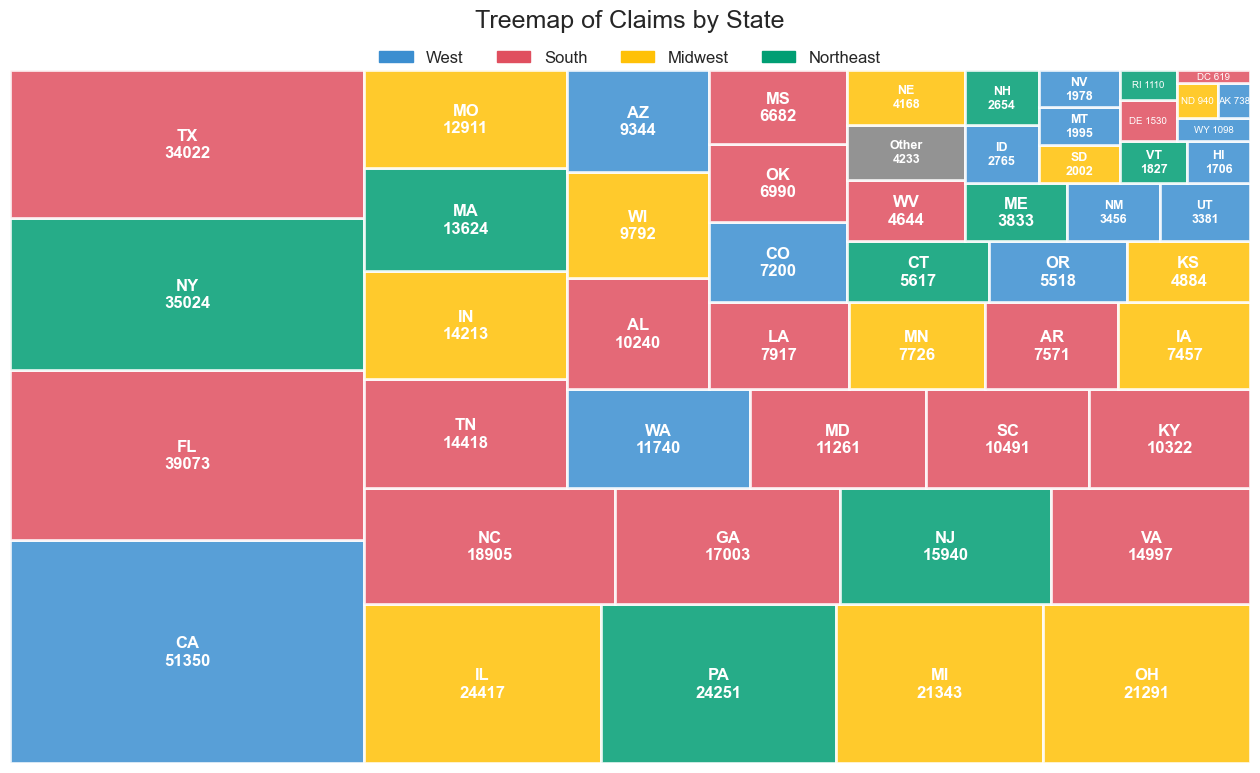

In [91]:
# Tree Map Visualization

# Data Prep
state_counts = train_merged['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

# Define Colors by Region
region_map = {
    'West': ['CA', 'OR', 'WA', 'NV', 'ID', 'UT', 'AZ', 'MT', 'WY', 'CO', 'NM', 'AK', 'HI'],
    'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH'],
    'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'DC', 'MD', 'DE'],
    'Northeast': ['PA', 'NJ', 'NY', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']
}
state_to_region = {state: region for region, states in region_map.items() for state in states}
region_colors = {
    'West': '#3B8ED0', 'South': '#E04F5F', 'Midwest': '#FFC107',
    'Northeast': '#009E73', 'Unknown': '#808080'
}
colors = [region_colors.get(state_to_region.get(s, 'Unknown'), 'Unknown') for s in state_counts['State']]

# Setup Plot
plt.figure(figsize=(16, 9))

# Plot Rectangles ONLY (No labels yet)
ax = squarify.plot(
    sizes=state_counts['Count'],
    label=None,
    color=colors,
    alpha=0.85,
    pad=0,
    norm_x=100,
    norm_y=100,
    edgecolor='white',
    linewidth=2
)

# Smart Labeling Loop (Dynamic Text formatting)
rects = ax.patches

# ZIP parameters: The rectangles, the State names, and the Counts
for rect, state, count in zip(rects, state_counts['State'], state_counts['Count']):
    w = rect.get_width()
    h = rect.get_height()
    x = rect.get_x() + w / 2
    y = rect.get_y() + h / 2

    # LOGIC
    if w < 5 or h < 5: # Slightly raised threshold to catch DC/AK
        font_size = 7
        font_weight = 'normal'
        # KEY CHANGE: Use space instead of newline for tiny boxes
        label_text = f"{state} {count}"
    elif w < 8 or h < 8:
        font_size = 9
        font_weight = 'bold'
        label_text = f"{state}\n{count}"
    else:
        font_size = 12
        font_weight = 'bold'
        label_text = f"{state}\n{count}"

    plt.text(
        x, y,
        label_text,
        va='center', ha='center',
        fontsize=font_size,
        color='white',
        fontweight=font_weight
    )

# Legend & Title
handles = [plt.Rectangle((0,0),1,1, color=c) for c in region_colors.values() if c != '#808080']
plt.legend(handles, region_colors.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False, fontsize=12)
plt.title('Treemap of Claims by State', fontsize=18, y=1.05)
plt.axis('off')

plt.show()

## County

In [92]:
train_merged['County'].nunique()

314

In [93]:
train_merged['County'].value_counts(dropna=False).head()

County
200    15957
10     13982
20     12632
470    12278
60     11995
Name: count, dtype: int64

In [94]:
# How many County State Combination do we have ??
train_merged[['County','State']].value_counts().shape[0]

3106

### Data Transformation : Numerical codes to Actual Names

after looking at the county column , I decided to search up the cms.gov/ if i can find what coding did they use for the counties , I found this page :

Files for FY 2011 Final Rule and Correction Notice
https://www.cms.gov/medicare/medicare-fee-for-service-payment/acuteinpatientpps/acute-inpatient-files-for-download-items/cms1255464

which includes
- County to CBSA Crosswalk File: This file lists the CBSA, SSA county code and FIPS county code for all counties. Any changes to the CBSAs through March 2010 have been incorporated. It also contains the old MSA (based on 1990 census data) and old MSA name to which each county was assigned prior to the implementation of CBSAs in FY 2005.

which can be downloaded from :
https://www.cms.gov/medicare/medicare-fee-for-service-payment/acuteinpatientpps/downloads/fy_11_fr_county_to_cbsa_xwalk.zip

I will use this file and the State column we have to transform this column

Our codes use the last 3 digits of the SSACD column

In [95]:
# Load the Crosswalk File
# We use sep='\t' because it is a tab-separated text file
crosswalk_path = '../docs/FY_11_FR_County_to_CBSA_Xwalk.txt'
df_crosswalk = pd.read_csv(crosswalk_path, sep='\t', encoding='latin1')

# Clean the SSA Code Column
# The file likely loaded SSACD as floats (e.g., 5200.0). We need 5-digit strings (05200).
df_crosswalk['SSACD'] = pd.to_numeric(df_crosswalk['SSACD'], errors='coerce') # Handle errors
df_crosswalk = df_crosswalk.dropna(subset=['SSACD']) # Drop bad lines
df_crosswalk['SSACD_Clean'] = df_crosswalk['SSACD'].astype(int).astype(str).str.zfill(5)

# Create the Merge Key (Last 3 Digits)
# Your 'County' column corresponds to the last 3 digits of the SSA Code
df_crosswalk['County_Key'] = df_crosswalk['SSACD_Clean'].str[-3:].astype(int)

# Merge with your Main Data
# We match on both 'State' and the new 'County_Key'
# assuming your main dataframe is named 'train_merged'
train_merged = pd.merge(
    train_merged,
    df_crosswalk[['State', 'County_Key', 'County']], # Keep only necessary cols
    left_on=['State', 'County'],      # Your columns
    right_on=['State', 'County_Key'], # Crosswalk columns
    how='left'
)

# Cleanup
# Rename the new column to something useful and drop the key
train_merged.rename(columns={'County_y': 'County_Name', 'County_x': 'County_Code'}, inplace=True)
train_merged.drop(columns=['County_Key'], inplace=True)



In [96]:
# Define your manual mapping dictionary
fill_map = {
    'Other': 'Other',
    'NH': 'HILLSBOROUGH',
    'AK': 'ANCHORAGE',
    'VA': 'FAIRFAX',
    'CA': 'LOS ANGELES',
    'IL': 'COOK'
}

# Loop through and apply the fill only where County is NaN
for state, county_name in fill_map.items():
    # Condition: State matches AND County Name is Null
    mask = (train_merged['State'] == state) & (train_merged['County_Name'].isna())
    train_merged.loc[mask, 'County_Name'] = county_name

# Check the results
print(train_merged[train_merged['State'].isin(fill_map.keys())]['County_Name'].value_counts(dropna=False).head(10))

County_Name
LOS ANGELES       12813
COOK               8979
SAN DIEGO          5087
ORANGE             4408
Other              4233
RIVERSIDE          2606
SANTA CLARA        2386
SACRAMENTO         2196
SAN BERNARDINO     1834
DU PAGE            1739
Name: count, dtype: int64


In [97]:
train_merged.drop(columns=['County_Code'], inplace=True)

## ChronicCond Columns

ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,
ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,
ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,
ChronicCond_rheumatoidarthritis,ChronicCond_stroke

In [98]:
chronic_cols = [
    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
    'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
    'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
    'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'
]

# The result will have 1 and 2 as the index (rows)
counts_chronic = train_merged[chronic_cols].apply(pd.Series.value_counts,dropna=False)

display(counts_chronic)

ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease  \
1                 224327                    329583                     229984   
2                 333884                    228628                     328227   

   ChronicCond_Cancer  ChronicCond_ObstrPulmonary  ChronicCond_Depression  \
1               84505                      174681                  242714   
2              473706                      383530                  315497   

   ChronicCond_Diabetes  ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  \
1                393759                     423830                    177314   
2                164452                     134381                    380897   

   ChronicCond_rheumatoidarthritis  ChronicCond_stroke  
1                           173699               56781  
2                           384512              501430

after doing my research , I found that according to CMS Linkable 2008–2010 Medicare Data Entrepreneurs’ Synthetic Public Use File (DE-SynPUF) :

https://www.cms.gov/files/document/de-10-codebook.pdf-0

In page 27-37 it was mentioned that those 11 columns were mapped as follows:
- Label Yes was Coded to '1'
- Label No was Coded to '2'

for easier modeling and encoding for next steps , we will label No as 0

In [99]:
# the replacement (Map 2 to 0)
# This modifies the actual DataFrame 'df'
train_merged[chronic_cols] = train_merged[chronic_cols].replace(2, 0)

# Display the new counts to confirm
# The rows will now be 0, 1 (instead of 1, 2, NaN)
counts_df = train_merged[chronic_cols].apply(pd.Series.value_counts, dropna=False)

display(counts_df)

ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease  \
0                 333884                    228628                     328227   
1                 224327                    329583                     229984   

   ChronicCond_Cancer  ChronicCond_ObstrPulmonary  ChronicCond_Depression  \
0              473706                      383530                  315497   
1               84505                      174681                  242714   

   ChronicCond_Diabetes  ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  \
0                164452                     134381                    380897   
1                393759                     423830                    177314   

   ChronicCond_rheumatoidarthritis  ChronicCond_stroke  
0                           384512              501430  
1                           173699               56781

## PotentialFraud (Target Variable)

In [100]:
vc = train_merged['PotentialFraud'].value_counts(dropna=False)
result = pd.DataFrame({
    'count': vc,
    'percentage': (vc / vc.sum() * 100).round(2).astype(str) + '%'
})
result

count percentage
PotentialFraud                   
No              345415     61.88%
Yes             212796     38.12%

In [101]:
train_merged['PotentialFraud'].replace({'Yes': 1, 'No': 0}, inplace=True)

In [102]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 61 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   BeneID                                 558211 non-null  object 
 1   ClaimID                                558211 non-null  object 
 2   Provider                               558211 non-null  object 
 3   InscClaimAmtReimbursed                 558211 non-null  int64  
 4   AttendingPhysician                     556703 non-null  object 
 5   OperatingPhysician                     114447 non-null  object 
 6   OtherPhysician                         199736 non-null  object 
 7   ClmAdmitDiagnosisCode                  558211 non-null  object 
 8   DeductibleAmtPaid                      558211 non-null  int64  
 9   DiagnosisGroupCode                     558211 non-null  object 
 10  IsMale                                 558211 non-null  

In [103]:
# Calculate the number of null values
null_sum = train_merged.isnull().sum()

# Calculate the percentage of null values
null_pct = (train_merged.isnull().sum() / len(train_merged)) * 100

# Calculate the number of unique values
nunique = train_merged.nunique()

# Combine these into a single DataFrame for a clean view
summary_df = pd.DataFrame({
    'Null Count': null_sum,
    'Null Percentage': null_pct,
    'Unique Values': nunique ,
})

# Display the summary
display(summary_df)

Null Count  Null Percentage  \
BeneID                                          0         0.000000   
ClaimID                                         0         0.000000   
Provider                                        0         0.000000   
InscClaimAmtReimbursed                          0         0.000000   
AttendingPhysician                           1508         0.270149   
OperatingPhysician                         443764        79.497538   
OtherPhysician                             358475        64.218548   
ClmAdmitDiagnosisCode                           0         0.000000   
DeductibleAmtPaid                               0         0.000000   
DiagnosisGroupCode                              0         0.000000   
IsMale                                          0         0.000000   
RenalDiseaseIndicator                           0         0.000000   
State                                           0         0.000000   
NoOfMonths_PartACov                             0         0.000000   
NoOfMonths_PartBCov                             0         0.000000   
ChronicCond_Alzheimer                           0         0.000000   
ChronicCond_Heartfailure                        0         0.000000   
ChronicCond_KidneyDisease                       0         0.000000   
ChronicCond_Cancer                              0         0.000000   
ChronicCond_ObstrPulmonary                      0         0.000000   
ChronicCond_Depression                          0         0.000000   
ChronicCond_Diabetes                            0         0.000000   
ChronicCond_IschemicHeart                       0         0.000000   
ChronicCond_Osteoporasis                        0         0.000000   
ChronicCond_rheumatoidarthritis                 0         0.000000   
ChronicCond_stroke                              0         0.000000   
IPAnnualReimbursementAmt                        0         0.000000   
IPAnnualDeductibleAmt                           0         0.000000   
OPAnnualReimbursementAmt                        0         0.000000   
OPAnnualDeductibleAmt                           0         0.000000   
PotentialFraud                                  0         0.000000   
IsInpatient                                     0         0.000000   
IsPostDischargeBilling                          0         0.000000   
ClaimDurationDays                               0         0.000000   
Age                                             0         0.000000   
IsDead                                          0         0.000000   
ClmDiagnosisCount                               0         0.000000   
ClmProceduresCount                              0         0.000000   
Congenital Anomalies                            0         0.000000   
Diseases Of The Circulatory System              0         0.000000   
Diseases Of The Digestive System                0         0.000000   
Diseases Of The Genitourinary System            0         0.000000   
Diseases Of The Nervous System                  0         0.000000   
Diseases Of The Respiratory System              0         0.000000   
Diseases Of The Skin                            0         0.000000   
Infectious And Parasitic Diseases               0         0.000000   
Injury, Poisoning & External Causes             0         0.000000   
Mental Disorders                                0         0.000000   
Musculoskeletal & Connective Tissue             0         0.000000   
Neoplasms                                       0         0.000000   
Pregnancy, Childbirth & Perinatal               0         0.000000   
Procedures & Surgeries                          0         0.000000   
Supplementary Factors (V-Codes)                 0         0.000000   
Symptoms, Signs, And Ill-Defined                0         0.000000   
Systemic, Metabolic & Blood Disorders           0         0.000000   
UnknownCodesCount                               0         0.000000   
IsWhiteRace                                     0

In [104]:
display(train_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 61 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   BeneID                                 558211 non-null  object 
 1   ClaimID                                558211 non-null  object 
 2   Provider                               558211 non-null  object 
 3   InscClaimAmtReimbursed                 558211 non-null  int64  
 4   AttendingPhysician                     556703 non-null  object 
 5   OperatingPhysician                     114447 non-null  object 
 6   OtherPhysician                         199736 non-null  object 
 7   ClmAdmitDiagnosisCode                  558211 non-null  object 
 8   DeductibleAmtPaid                      558211 non-null  int64  
 9   DiagnosisGroupCode                     558211 non-null  object 
 10  IsMale                                 558211 non-null  

None

In [105]:
train_merged.describe(include='all')

BeneID   ClaimID  Provider  InscClaimAmtReimbursed  \
count      558211    558211    558211           558211.000000   
unique     138556    558211      5410                     NaN   
top     BENE59303  CLM46614  PRV51459                     NaN   
freq           29         1      8240                     NaN   
mean          NaN       NaN       NaN              997.012133   
std           NaN       NaN       NaN             3821.534891   
min           NaN       NaN       NaN                0.000000   
25%           NaN       NaN       NaN               40.000000   
50%           NaN       NaN       NaN               80.000000   
75%           NaN       NaN       NaN              300.000000   
max           NaN       NaN       NaN           125000.000000   

       AttendingPhysician OperatingPhysician OtherPhysician  \
count              556703             114447         199736   
unique              82063              35315          46457   
top             PHY330576          PHY330576      PHY412132   
freq                 2534                424           1247   
mean                  NaN                NaN            NaN   
std                   NaN                NaN            NaN   
min                   NaN                NaN            NaN   
25%                   NaN                NaN            NaN   
50%                   NaN                NaN            NaN   
75%                   NaN                NaN            NaN   
max                   NaN                NaN            NaN   

       ClmAdmitDiagnosisCode  DeductibleAmtPaid DiagnosisGroupCode  \
count                 558211      558211.000000             558211   
unique                    17                NaN                737   
top                  Unknown                NaN     Not applicable   
freq                  412312                NaN             517737   
mean                     NaN          80.014804                NaN   
std                      NaN         276.656578                NaN   
min                      NaN           0.000000                NaN   
25%                      NaN           0.000000                NaN   
50%                      NaN           0.000000                NaN   
75%                      NaN           0.000000                NaN   
max                      NaN        1068.000000                NaN   

               IsMale  RenalDiseaseIndicator   State  NoOfMonths_PartACov  \
count   558211.000000          558211.000000  558211        558211.000000   
unique            NaN                    NaN      52                  NaN   
top               NaN                    NaN      CA                  NaN   
freq              NaN                    NaN   51350                  NaN   
mean         0.421162               0.196786     NaN            11.931472   
std          0.493746               0.397569     NaN             0.889712   
min          0.000000               0.000000     NaN             0.000000   
25%          0.000000               0.000000     NaN            12.000000   
50%          0.000000               0.000000     NaN            12.000000   
75%          1.000000               0.000000     NaN            12.000000   
max          1.000000               1.000000     NaN            12.000000   

        NoOfMonths_PartBCov  ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
count          558211.00000          558211.000000             558211.000000   
unique                  NaN                    NaN                       NaN   
top                     NaN                    NaN                       NaN   
freq                    NaN                    NaN                       NaN   
mean               11.93877               0.401868                  0.590427   
std                 0.78590               0.490276                  0.491755   
min                 0.00000               0.000000                  0.000000   
25%                12.00000               0.000000                 

In [106]:
def get_dominance_stats(df):
    stats = []
    for col in df.columns:
        # Get value counts (normalize=True gives percentage)
        vc = df[col].value_counts(dropna=False , normalize=True)

        # Skip if column is empty
        if len(vc) == 0:
            continue

        top_val = vc.index[0]
        top_pct = vc.iloc[0]
        nunique = df[col].nunique() # Calculate number of unique values

        stats.append({
            'Feature': col,
            'Dominant_Value': top_val,
            'Dominance_%': round(top_pct * 100, 6),
            'N_Unique': nunique  # Added unique count
        })

    # Create DataFrame and sort by highest dominance
    return pd.DataFrame(stats).sort_values('Dominance_%', ascending=False)

# Run it on your dataframe
dominance_df = get_dominance_stats(train_merged)
display(dominance_df)

Feature  Dominant_Value  Dominance_%  \
32                 IsPostDischargeBilling               0    99.996955   
51                 Procedures & Surgeries               0    99.992476   
50      Pregnancy, Childbirth & Perinatal               0    99.924401   
38                   Congenital Anomalies               0    99.418320   
13                    NoOfMonths_PartACov              12    99.374968   
35                                 IsDead               0    99.259957   
14                    NoOfMonths_PartBCov              12    99.230936   
58                         IsHispanicRace               0    97.882521   
45      Infectious And Parasitic Diseases               0    96.672226   
59                            IsOtherRace               0    96.468181   
55                      UnknownCodesCount               0    96.318238   
44                   Diseases Of The Skin               0    95.983956   
37                     ClmProceduresCount               0    95.824160   
31                            IsInpatient               0    92.749337   
9                      DiagnosisGroupCode  Not applicable    92.749337   
49                              Neoplasms               0    91.629688   
46    Injury, Poisoning & External Causes               0    91.565197   
47                       Mental Disorders               0    90.386789   
57                            IsBlackRace               0    90.032443   
42         Diseases Of The Nervous System               0    89.905788   
40       Diseases Of The Digestive System               0    89.894681   
25                     ChronicCond_stroke               0    89.828040   
43     Diseases Of The Respiratory System               0    89.202828   
8                       DeductibleAmtPaid               0    88.980869   
41   Diseases Of The Genitourinary System               0    86.384539   
18                     ChronicCond_Cancer               0    84.861459   
56                            IsWhiteRace               1    84.383145   
33                      ClaimDurationDays               0    81.322833   
11                  RenalDiseaseIndicator               0    80.321420   
5                      OperatingPhysician             NaN    79.497538   
48    Musculoskeletal & Connective Tissue               0    79.151074   
22              ChronicCond_IschemicHeart               1    75.926487   
7                   ClmAdmitDiagnosisCode         Unknown    73.863109   
53       Symptoms, Signs, And Ill-Defined               0    73.013072   
21                   ChronicCond_Diabetes               1    70.539456   
24        ChronicCond_rheumatoidarthritis               0    68.882913   
19             ChronicCond_ObstrPulmonary               0    68.706994   
23               ChronicCond_Osteoporasis               0    68.235309   
54  Systemic, Metabolic & Blood Disorders               0    66.917169   
26               IPAnnualReimbursementAmt               0    66.583425   
27                  IPAnnualDeductibleAmt               0    66.151867   
6                          OtherPhysician             NaN    64.218548   
39     Diseases Of The Circulatory System               0    63.399503   
52        Supplementary Factors (V-Codes)               0    62.341480   
30                         PotentialFraud               0    61.878931   
15                  ChronicCond_Alzheimer               0    59.813225   
16               ChronicCond_Heartfailure               1    59.042728   
17              ChronicCond_KidneyDisease               0    58.799809   
10                                 IsMale               0    57.883847   
20                 ChronicCond_Depression               0    56.519309   
36                      ClmDiagnosisCount               1    33.168999   
3                  InscClaimAmtReimbursed             100     9.487452   
12                                  State              CA     9.199030   
29                  OPAnnualDeductible

## Final Data Split

In [107]:
# Create a unique list of Providers and their Fraud Label
# We group by Provider and take the 'first' label (assuming a Provider is either Fraud or Not)
unique_providers = train_merged.groupby('Provider')['PotentialFraud'].first()

# Split the PROVIDER (not the rows yet)
# This ensures 85% of providers are in train, 15% in test
# And 'stratify' ensures the ratio of Fraudulent Providers is maintained
train_provider_ids, test_provider_ids = train_test_split(
    unique_providers.index,
    test_size=0.15,
    stratify=unique_providers.values,
    random_state=42
)

# Create the final DataFrames by filtering the original data
# We select rows only where the Provider exists in our split lists
train_split_df = train_merged[train_merged['Provider'].isin(train_provider_ids)].copy()
test_split_df = train_merged[train_merged['Provider'].isin(test_provider_ids)].copy()

# Reassign variable names as requested
train_merged = train_split_df
test_merged = test_split_df

# Save to CSV
train_merged.to_csv('../data/train_merged.csv', index=False)
test_merged.to_csv('../data/test_merged.csv', index=False)

# --- VERIFICATION ---
print("--- Split Results ---")
print(f"Total Unique Providers: {len(unique_providers)}")
print(f"Train Providers: {len(train_provider_ids)}")
print(f"Test Providers:  {len(test_provider_ids)}")

print("\n--- Row Counts ---")
print(f"Train Rows: {len(train_merged)}")
print(f"Test Rows:  {len(test_merged)}")

print("\n--- Leakage Check ---")
# If this prints any IDs, we have a problem. If empty, we are good.
overlap = set(train_merged['Provider']).intersection(set(test_merged['Provider']))
print(f"Providers found in both sets: {len(overlap)}")

print("\n--- Fraud Ratio Verification (By Provider) ---")
print("Train Set Fraud Ratio:", train_merged.groupby('Provider')['PotentialFraud'].first().value_counts(normalize=True).get(1, 0))
print("Test Set Fraud Ratio: ", test_merged.groupby('Provider')['PotentialFraud'].first().value_counts(normalize=True).get(1, 0))

--- Split Results ---
Total Unique Providers: 5410
Train Providers: 4598
Test Providers:  812

--- Row Counts ---
Train Rows: 458684
Test Rows:  99527

--- Leakage Check ---
Providers found in both sets: 0

--- Fraud Ratio Verification (By Provider) ---
Train Set Fraud Ratio: 0.09351892127011745
Test Set Fraud Ratio:  0.09359605911330049


# Aggregation strategy

In [108]:
train_merged.drop(columns=['PotentialFraud'], inplace=True)

## Helper Functions

In [109]:
def p99_5(x):   return x.quantile(0.995)

# This allows our function to look up which value is globally more popular
global_counts = {}
for col in train_merged.columns:
    try:
        # Store value counts as a dictionary for fast lookup
        global_counts[col] = train_merged[col].value_counts().to_dict()
    except:
        pass # Skip columns that can't be counted (e.g. specialized objects)

def get_mode(x):
    # Get the mode(s) for the current group
    modes = x.mode()

    if modes.empty:
        return "None"
    elif len(modes) == 1:
        return modes.iloc[0]
    else:
        # TIE-BREAKER LOGIC:
        # If there are multiple modes (e.g., both 'A' and 'B' appear 5 times in this group),
        # we check which one is more frequent in the GLOBAL dataset.

        col_name = x.name # The name of the column being processed

        if col_name in global_counts:
            # Sort the modes based on their global count (descending)
            # We use .get(val, 0) to handle cases where a value might be rare or missing
            best_mode = sorted(modes, key=lambda val: global_counts[col_name].get(val, 0), reverse=True)[0]
            return best_mode
        else:
            # Fallback if global counts aren't available: just take the first one
            return modes.iloc[0]

def get_mode_count(x):
    return x.value_counts().iloc[0] if not x.value_counts().empty else 0

## Data-Driven Feature Engineering Strategy
Based on statistical properties of healthcare data

In [110]:
# AGGREGATION METRIC GROUPS

#  Standard Statistical Distributions
# For skewed financial data (heavy-tailed distributions)
SKEWED_CONTINUOUS = ['mean', 'std', p99_5]

# For count data with potential outliers (Disease categories)
COUNT_WITH_OUTLIERS = ['max', 'sum', 'std']

# For standard counts (Diagnosis/Procedure counts)
COUNT_BASIC = ['mean', 'std', 'max']

# For discrete durations
DURATION_METRICS = ['min', 'max', 'mean', 'std']

#  Categorical & ID Handling
# For high-cardinality IDs (Provider/Beneficiary)
HIGH_CARDINALITY_ID = ['count', 'nunique', get_mode_count]

# For categorical data with moderate cardinality (Codes/Geography)
MODERATE_CATEGORICAL = ['nunique', get_mode, get_mode_count]

#  Binary & Demographic Logic
# For standard binary/boolean flags
BINARY_DISTRIBUTION = ['mean', 'std', 'any', 'all']

# For Demographics (Gender & Race) - Focus on variance/presence
DEMOGRAPHIC_VARIANCE = ['any', 'std']

# For Age Distribution
AGE_METRICS = ['std', 'min', 'max']

#  Domain-Specific Handling
# For Chronic Conditions (Flag count is sufficient)
CHRONIC_CONDITION = ['sum']

# For Sparse/Rare Events (Zero-inflated data)
# Used when data is >96% zeros or constant; 'std' captures volatility/variance.
SPARSE_VARIANCE = 'std'

# For Ultra-Sparse Events
# Used when positives are negligible (e.g., <0.01%); 'any' is sufficient.
RARE_EVENT_BOOL = 'any'


In [111]:
# DOMAIN-INFORMED AGGREGATION MAPPING

aggregation_dict = {
    # ---------------------------------------------------------
    # IDENTIFIERS (Patient & Provider)
    # ---------------------------------------------------------
    'BeneID':                HIGH_CARDINALITY_ID,
    'ClaimID':               HIGH_CARDINALITY_ID,
    'AttendingPhysician':    HIGH_CARDINALITY_ID,
    'OperatingPhysician':    HIGH_CARDINALITY_ID,
    'OtherPhysician':        HIGH_CARDINALITY_ID,

    # ---------------------------------------------------------
    # CLINICAL CODING & GEOGRAPHY
    # ---------------------------------------------------------
    'ClmAdmitDiagnosisCode': MODERATE_CATEGORICAL,
    'DiagnosisGroupCode':    MODERATE_CATEGORICAL,
    'State':                 MODERATE_CATEGORICAL,
    'County_Name':           MODERATE_CATEGORICAL,

    # ---------------------------------------------------------
    # FINANCIAL TRANSACTIONS (Skewed Data)
    # ---------------------------------------------------------
    'InscClaimAmtReimbursed':   SKEWED_CONTINUOUS,
    'DeductibleAmtPaid':        SKEWED_CONTINUOUS,
    'IPAnnualReimbursementAmt': SKEWED_CONTINUOUS,
    'IPAnnualDeductibleAmt':    SKEWED_CONTINUOUS,
    'OPAnnualReimbursementAmt': SKEWED_CONTINUOUS,
    'OPAnnualDeductibleAmt':    SKEWED_CONTINUOUS,

    # ---------------------------------------------------------
    # PATIENT DEMOGRAPHICS
    # ---------------------------------------------------------
    'Age':                      AGE_METRICS,
    'IsMale':                   DEMOGRAPHIC_VARIANCE,

    # Racial Composition
    'IsWhiteRace':              DEMOGRAPHIC_VARIANCE,
    'IsBlackRace':              DEMOGRAPHIC_VARIANCE,
    'IsHispanicRace':           DEMOGRAPHIC_VARIANCE,
    'IsOtherRace':              DEMOGRAPHIC_VARIANCE,

    # Health Status Indicators
    'RenalDiseaseIndicator':    BINARY_DISTRIBUTION,
    'IsInpatient':              BINARY_DISTRIBUTION,

    # Ultra-Sparse Indicators
    # 17 rows / 558,211 are 1; rest are 0.
    'IsPostDischargeBilling':   RARE_EVENT_BOOL,
    # 4,131 rows / 558,211 are 1; rest are 0.
    'IsDead':                   RARE_EVENT_BOOL,

    # ---------------------------------------------------------
    # CHRONIC CONDITIONS
    # ---------------------------------------------------------
    'ChronicCond_Alzheimer':           CHRONIC_CONDITION,
    'ChronicCond_Heartfailure':        CHRONIC_CONDITION,
    'ChronicCond_KidneyDisease':       CHRONIC_CONDITION,
    'ChronicCond_Cancer':              CHRONIC_CONDITION,
    'ChronicCond_ObstrPulmonary':      CHRONIC_CONDITION,
    'ChronicCond_Depression':          CHRONIC_CONDITION,
    'ChronicCond_Diabetes':            CHRONIC_CONDITION,
    'ChronicCond_IschemicHeart':       CHRONIC_CONDITION,
    'ChronicCond_Osteoporasis':        CHRONIC_CONDITION,
    'ChronicCond_rheumatoidarthritis': CHRONIC_CONDITION,
    'ChronicCond_stroke':              CHRONIC_CONDITION,

    # ---------------------------------------------------------
    # SERVICE UTILIZATION
    # ---------------------------------------------------------
    'ClaimDurationDays':    DURATION_METRICS,
    'ClmDiagnosisCount':    COUNT_BASIC,
    'ClmProceduresCount':   COUNT_BASIC,

    # Coverage Months (Heavily skewed, 99% constant at 12 months)
    # Variance highlights the <1% non-constant cases.
    'NoOfMonths_PartACov':  SPARSE_VARIANCE,
    'NoOfMonths_PartBCov':  SPARSE_VARIANCE,

    # ---------------------------------------------------------
    # DISEASE CATEGORY COUNTS
    # ---------------------------------------------------------
    # High Volume / Outlier Prone
    'Diseases Of The Circulatory System':    COUNT_WITH_OUTLIERS,
    'Diseases Of The Digestive System':      COUNT_WITH_OUTLIERS,
    'Diseases Of The Genitourinary System':  COUNT_WITH_OUTLIERS,
    'Diseases Of The Nervous System':        COUNT_WITH_OUTLIERS,
    'Diseases Of The Respiratory System':    COUNT_WITH_OUTLIERS,
    'Injury, Poisoning & External Causes':   COUNT_WITH_OUTLIERS,
    'Mental Disorders':                      COUNT_WITH_OUTLIERS,
    'Musculoskeletal & Connective Tissue':   COUNT_WITH_OUTLIERS,
    'Neoplasms':                             COUNT_WITH_OUTLIERS,
    'Supplementary Factors (V-Codes)':       COUNT_WITH_OUTLIERS,
    'Symptoms, Signs, And Ill-Defined':      COUNT_WITH_OUTLIERS,
    'Systemic, Metabolic & Blood Disorders': COUNT_WITH_OUTLIERS,

    # High Sparsity / Zero-Inflated
    # (>96.5% zeros); 'std' captures volatility from zero baseline.
    'Congenital Anomalies':              SPARSE_VARIANCE,
    'Diseases Of The Skin':              SPARSE_VARIANCE,
    'Infectious And Parasitic Diseases': SPARSE_VARIANCE,
    'Pregnancy, Childbirth & Perinatal': SPARSE_VARIANCE,
    'UnknownCodesCount':                 SPARSE_VARIANCE,
    'Procedures & Surgeries':            SPARSE_VARIANCE,
}

In [112]:
# Grouping by Provider and Aggregating by our defined aggergates above
train_merged_for_agg = train_merged.copy()
aggregated_df = train_merged_for_agg.groupby('Provider').agg(aggregation_dict)

# Flatten the multi-level column names
aggregated_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_df.columns.values]

In [113]:
# Merge back the fraud labels
final_df = aggregated_df.merge(train_labels, left_index=True, right_on='Provider', how='left')

# Set Provider as index
final_df.set_index('Provider', inplace=True)

print(f"Original shape: {train_merged.shape}")
print(f"Aggregated shape: {final_df.shape}")
print(f"Number of providers: {len(final_df)}")

# Optional: Display some basic info about the aggregated dataframe
print("\nAggregated DataFrame Info:")
print(final_df.info())

Original shape: (458684, 60)
Aggregated shape: (4598, 134)
Number of providers: 4598

Aggregated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4598 entries, PRV51001 to PRV57763
Columns: 134 entries, BeneID_count to PotentialFraud
dtypes: bool(11), float64(56), int64(62), object(5)
memory usage: 4.4+ MB
None


In [114]:
final_df.columns

Index(['BeneID_count', 'BeneID_nunique', 'BeneID_get_mode_count',
       'ClaimID_count', 'ClaimID_nunique', 'ClaimID_get_mode_count',
       'AttendingPhysician_count', 'AttendingPhysician_nunique',
       'AttendingPhysician_get_mode_count', 'OperatingPhysician_count',
       ...
       'Systemic, Metabolic & Blood Disorders_max',
       'Systemic, Metabolic & Blood Disorders_sum',
       'Systemic, Metabolic & Blood Disorders_std', 'Congenital Anomalies_std',
       'Diseases Of The Skin_std', 'Infectious And Parasitic Diseases_std',
       'Pregnancy, Childbirth & Perinatal_std', 'UnknownCodesCount_std',
       'Procedures & Surgeries_std', 'PotentialFraud'],
      dtype='object', length=134)

In [115]:
bool_columns = final_df.select_dtypes(include=['bool']).columns
final_df[bool_columns] = final_df[bool_columns].astype(int)

In [116]:
final_df['PotentialFraud'].replace({'Yes': 1, 'No': 0}, inplace=True)

In [117]:
# Calculate the sum of nulls for each column
null_counts = final_df.isnull().sum()

# Filter to show only columns with more than 0 nulls
print(null_counts[null_counts > 0])

InscClaimAmtReimbursed_std                   210
DeductibleAmtPaid_std                        210
IPAnnualReimbursementAmt_std                 210
IPAnnualDeductibleAmt_std                    210
OPAnnualReimbursementAmt_std                 210
OPAnnualDeductibleAmt_std                    210
Age_std                                      210
IsMale_std                                   210
IsWhiteRace_std                              210
IsBlackRace_std                              210
IsHispanicRace_std                           210
IsOtherRace_std                              210
RenalDiseaseIndicator_std                    210
IsInpatient_std                              210
ClaimDurationDays_std                        210
ClmDiagnosisCount_std                        210
ClmProceduresCount_std                       210
NoOfMonths_PartACov_std                      210
NoOfMonths_PartBCov_std                      210
Diseases Of The Circulatory System_std       210
Diseases Of The Dige

In [118]:
final_df = final_df.fillna(0)

In [119]:
# Keep only columns where the number of unique values is > 1
final_df = final_df.loc[:, final_df.nunique() > 1]

# Print how many were dropped
final_df.nunique()

BeneID_count                                  539
BeneID_nunique                                420
BeneID_get_mode_count                          23
ClaimID_count                                 539
ClaimID_nunique                               539
AttendingPhysician_count                      545
AttendingPhysician_nunique                    156
AttendingPhysician_get_mode_count             262
OperatingPhysician_count                      219
OperatingPhysician_nunique                     86
OperatingPhysician_get_mode_count             114
OtherPhysician_count                          307
OtherPhysician_nunique                        108
OtherPhysician_get_mode_count                 164
ClmAdmitDiagnosisCode_nunique                  17
ClmAdmitDiagnosisCode_get_mode                 15
ClmAdmitDiagnosisCode_get_mode_count          471
DiagnosisGroupCode_nunique                    127
DiagnosisGroupCode_get_mode                   159
DiagnosisGroupCode_get_mode_count             535


In [120]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4598 entries, PRV51001 to PRV57763
Columns: 133 entries, BeneID_count to PotentialFraud
dtypes: float64(56), int64(73), object(4)
memory usage: 4.7+ MB


In [121]:
non_numeric_cols = final_df.select_dtypes(exclude=['number']).columns.tolist()

print("Non-numeric columns and their unique value counts:")
print("=" * 50)
for col in non_numeric_cols:
    unique_count = final_df[col].nunique()
    print(f"{col:<25} : {unique_count:>6} unique values")

Non-numeric columns and their unique value counts:
ClmAdmitDiagnosisCode_get_mode :     15 unique values
DiagnosisGroupCode_get_mode :    159 unique values
State_get_mode            :     52 unique values
County_Name_get_mode      :   1138 unique values


In [122]:
# Create a set to keep track of columns we've already matched to avoid printing A=B and B=A
checked = set()

for i in range(len(final_df.columns)):
    col_1 = final_df.columns[i]

    if col_1 not in checked:
        # Find all columns that are equal to col_1
        # We start from i+1 to avoid comparing the column to itself or previous ones
        duplicates = []
        for j in range(i + 1, len(final_df.columns)):
            col_2 = final_df.columns[j]

            # .equals() is strict: it checks values, NaNs, and data types
            if final_df[col_1].equals(final_df[col_2]):
                duplicates.append(col_2)
                checked.add(col_2)

        if duplicates:
            print(f"Column '{col_1}' is identical to: {duplicates}")

Column 'BeneID_count' is identical to: ['ClaimID_count', 'ClaimID_nunique']


In [123]:
final_df.drop(columns=['ClaimID_count', 'ClaimID_nunique'],inplace=True, axis=1)

                          Feature  Association_Score
0  ClmAdmitDiagnosisCode_get_mode           0.112100
2                  State_get_mode           0.066143
1     DiagnosisGroupCode_get_mode           0.038948
3            County_Name_get_mode           0.000000


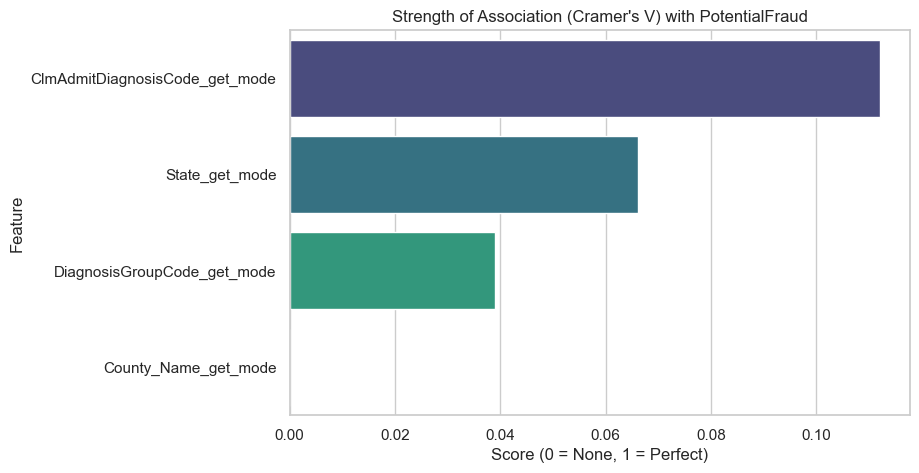

In [124]:
# Visualizing the need of non-numeric Columns we still have
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate Cramer's V for each non-numerical column vs PotentialFraud
results = {}
cat_cols = final_df.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    score = cramers_v(final_df[col], final_df['PotentialFraud'])
    results[col] = score

# Convert to DataFrame and sort
cramers_df = pd.DataFrame(list(results.items()), columns=['Feature', 'Association_Score'])
cramers_df = cramers_df.sort_values(by='Association_Score', ascending=False)

print(cramers_df)

# Visualizing
plt.figure(figsize=(8, 5))
sns.barplot(x='Association_Score', y='Feature', data=cramers_df, palette='viridis')
plt.title("Strength of Association (Cramer's V) with PotentialFraud")
plt.xlabel("Score (0 = None, 1 = Perfect)")
plt.show()

In [125]:
# All our categorical data has no real relation with the target variable
final_df.drop(columns=cat_cols,axis=1 , inplace=True)

In [126]:
#  class distributions
dominance_df = get_dominance_stats(final_df)
display(dominance_df)

Feature  Dominant_Value  Dominance_%  \
59                  IsPostDischargeBilling_any        0.000000    99.652023   
125                 Procedures & Surgeries_std        0.000000    99.260548   
43                             IsWhiteRace_any        1.000000    99.217051   
54                   RenalDiseaseIndicator_all        0.000000    98.825576   
41                                  IsMale_any        1.000000    94.475859   
123      Pregnancy, Childbirth & Perinatal_std        0.000000    94.062636   
72                       ClaimDurationDays_min        0.000000    93.062201   
58                             IsInpatient_all        0.000000    92.474989   
126                             PotentialFraud        0.000000    90.648108   
53                   RenalDiseaseIndicator_any        1.000000    87.081340   
82                     NoOfMonths_PartACov_std        0.000000    75.271857   
60                                  IsDead_any        0.000000    72.509787   
120                   Congenital Anomalies_std        0.000000    72.422793   
83                     NoOfMonths_PartBCov_std        0.000000    70.856894   
45                             IsBlackRace_any        1.000000    69.834711   
56                             IsInpatient_std        0.000000    68.834276   
48                          IsHispanicRace_std        0.000000    64.789039   
47                          IsHispanicRace_any        0.000000    64.702044   
124                      UnknownCodesCount_std        0.000000    64.484559   
80                      ClmProceduresCount_std        0.000000    63.745107   
14                  DiagnosisGroupCode_nunique        1.000000    62.570683   
79                     ClmProceduresCount_mean        0.000000    62.570683   
81                      ClmProceduresCount_max        0.000000    62.570683   
55                            IsInpatient_mean        0.000000    61.309265   
57                             IsInpatient_any        0.000000    61.309265   
50                             IsOtherRace_std        0.000000    52.892562   
49                             IsOtherRace_any        0.000000    52.762070   
73                       ClaimDurationDays_max       20.000000    52.740322   
16                               State_nunique        1.000000    52.653328   
78                       ClmDiagnosisCount_max        9.000000    39.756416   
122      Infectious And Parasitic Diseases_std        0.000000    39.647673   
25                     DeductibleAmtPaid_p99_5     1068.000000    35.558939   
121                   Diseases Of The Skin_std        0.000000    34.362766   
24                       DeductibleAmtPaid_std        0.000000    32.166159   
2                        BeneID_get_mode_count        1.000000    31.948673   
102                       Mental Disorders_max        1.000000    31.491953   
93          Diseases Of The Nervous System_max        1.000000    31.426707   
90    Diseases Of The Genitourinary System_max        2.000000    31.209221   
46                             IsBlackRace_std        0.000000    30.709004   
114       Symptoms, Signs, And Ill-Defined_max        2.000000    29.686820   
96      Diseases Of The Respiratory System_max        1.000000    29.273597   
117  Systemic, Metabolic & Blood Disorders_max        3.000000    28.403654   
108                              Neoplasms_max        2.000000    28.120922   
111        Supplementary Factors (V-Codes)_max        3.000000    27.751196   
87        Diseases Of The Digestive System_max        1.000000    25.793823   
23                      DeductibleAmtPaid_mean        0.000000    24.467160   
7                   OperatingPhysician_nunique        1.000000    23.292736   
101    Injury, Poisoning & External Causes_std        0.000000    23.053502   
71                      ChronicCond_stroke_sum        0.000000    22.814267   
110                              Neoplasms_std        0.000000    22.749021   
8         

## Correlation analysis

In [127]:
correlation_matrix = final_df.corr(numeric_only=True)
print("Correlation Matrix:")
display(correlation_matrix.style.background_gradient(cmap="coolwarm").format(precision=4))

Correlation Matrix:


In [128]:
corr_matrix = final_df.copy().corr(method='spearman')

# Find Perfect Correlations
perfect_pairs = []
cols = corr_matrix.columns

# Iterate through the upper triangle of the matrix to avoid duplicates and self-correlation
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):  # Start j from i+1 to skip diagonal (self) and lower triangle
        col_1 = cols[i]
        col_2 = cols[j]
        val = corr_matrix.loc[col_1, col_2]

        if abs(val) >=0:
            perfect_pairs.append((col_1, col_2, val))

results_df = pd.DataFrame(perfect_pairs)

In [129]:
# Create the DataFrame with clear column names
results_df = pd.DataFrame(perfect_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Filter for rows where 'BeneID_count' appears in Feature 1
BeneIDCorr = results_df[results_df['Feature 1'].str.contains('BeneID_count', case=False)]

BeneIDCorr

Feature 1                                  Feature 2  Correlation
0    BeneID_count                             BeneID_nunique     0.981089
1    BeneID_count                      BeneID_get_mode_count     0.776512
2    BeneID_count                   AttendingPhysician_count     0.999963
3    BeneID_count                 AttendingPhysician_nunique     0.636230
4    BeneID_count          AttendingPhysician_get_mode_count     0.822073
5    BeneID_count                   OperatingPhysician_count     0.939672
6    BeneID_count                 OperatingPhysician_nunique     0.775209
7    BeneID_count          OperatingPhysician_get_mode_count     0.787623
8    BeneID_count                       OtherPhysician_count     0.922364
9    BeneID_count                     OtherPhysician_nunique     0.691764
10   BeneID_count              OtherPhysician_get_mode_count     0.772541
11   BeneID_count              ClmAdmitDiagnosisCode_nunique     0.921595
12   BeneID_count       ClmAdmitDiagnosisCode_get_mode_count     0.981804
13   BeneID_count                 DiagnosisGroupCode_nunique     0.297277
14   BeneID_count          DiagnosisGroupCode_get_mode_count     0.962810
15   BeneID_count                              State_nunique     0.589029
16   BeneID_count                       State_get_mode_count     0.982331
17   BeneID_count                        County_Name_nunique     0.757600
18   BeneID_count                 County_Name_get_mode_count     0.919077
19   BeneID_count                InscClaimAmtReimbursed_mean     0.144379
20   BeneID_count                 InscClaimAmtReimbursed_std     0.346108
21   BeneID_count               InscClaimAmtReimbursed_p99_5     0.467700
22   BeneID_count                     DeductibleAmtPaid_mean     0.217772
23   BeneID_count                      DeductibleAmtPaid_std     0.520035
24   BeneID_count                    DeductibleAmtPaid_p99_5     0.425103
25   BeneID_count              IPAnnualReimbursementAmt_mean     0.077318
26   BeneID_count               IPAnnualReimbursementAmt_std     0.363670
27   BeneID_count             IPAnnualReimbursementAmt_p99_5     0.632764
28   BeneID_count                 IPAnnualDeductibleAmt_mean     0.029776
29   BeneID_count                  IPAnnualDeductibleAmt_std     0.383420
30   BeneID_count                IPAnnualDeductibleAmt_p99_5     0.630098
31   BeneID_count              OPAnnualReimbursementAmt_mean     0.267323
32   BeneID_count               OPAnnualReimbursementAmt_std     0.490854
33   BeneID_count             OPAnnualReimbursementAmt_p99_5     0.688180
34   BeneID_count                 OPAnnualDeductibleAmt_mean     0.240030
35   BeneID_count                  OPAnnualDeductibleAmt_std     0.475322
36   BeneID_count                OPAnnualDeductibleAmt_p99_5     0.686997
37   BeneID_count                                    Age_std     0.278096
38   BeneID_count                                    Age_min    -0.751846
39   BeneID_count                                    Age_max     0.737771
40   BeneID_count                                 IsMale_any     0.358291
41   BeneID_count                                 IsMale_std    -0.052707
42   BeneID_count                            IsWhiteRace_any     0.143092
43   BeneID_count                            IsWhiteRace_std     0.193998
44   BeneID_count                            IsBlackRace_any     0.557085
45   BeneID_count                            IsBlackRace_std     0.309492
46   BeneID_count                         IsHispanicRace_any     0.459981
47   BeneID_count                         IsHispanicRace_std     0.369984
48   BeneID_count                            IsOtherRace_any     0.541309
49   BeneID_count                            IsOtherRace_std     0.385321
50   BeneID_count                 RenalDiseaseIndicator_mean     0.159362
51   BeneID_count                  RenalDiseaseIndicator_std     0.139485
52   BeneID_count                  RenalDiseaseIndicator_any     0.507981
53   BeneID_

In [130]:

# Define the Map {Old_Column : New_Column}
transformation_map = {
    # Prevalence Rates
    'ChronicCond_IschemicHeart_sum': 'IschemicHeart_Rate',
    'ChronicCond_Diabetes_sum': 'Diabetes_Rate',
    'ChronicCond_Heartfailure_sum': 'HeartFailure_Rate',
    'ChronicCond_Depression_sum': 'Depression_Rate',
    'ChronicCond_Alzheimer_sum': 'Alzheimer_Rate',
    'ChronicCond_KidneyDisease_sum': 'KidneyDisease_Rate',
    'ChronicCond_Osteoporasis_sum': 'Osteoporosis_Rate',
    'ChronicCond_rheumatoidarthritis_sum': 'RheumArthritis_Rate',
    'ChronicCond_ObstrPulmonary_sum': 'ObstrPulmonary_Rate',
    'ChronicCond_Cancer_sum': 'Cancer_Rate',
    'ChronicCond_stroke_sum': 'Stroke_Rate',

    # Interaction Ratios
    'AttendingPhysician_count': 'AttPhys_per_Bene',
    'OperatingPhysician_count': 'OpPhys_per_Bene',
    'OtherPhysician_count': 'OtherPhys_per_Bene',

    # Concentration Scores
    'State_get_mode_count': 'State_Concentration',
    'ClmAdmitDiagnosisCode_get_mode_count': 'Diag_Concentration',
    'DiagnosisGroupCode_get_mode_count': 'GroupCode_Concentration',
    'County_Name_get_mode_count': 'County_Concentration',

    # Clinical Group Rates
    'Diseases Of The Circulatory System_sum': 'Circulatory_Rate',
    'Diseases Of The Genitourinary System_sum': 'Genitourinary_Rate',
    'Neoplasms_sum': 'Neoplasms_Rate',
    'Diseases Of The Nervous System_sum': 'NervousSystem_Rate',
    'Mental Disorders_sum': 'MentalDisorder_Rate',
    'Diseases Of The Digestive System_sum': 'Digestive_Rate',
    'Diseases Of The Respiratory System_sum': 'Respiratory_Rate',
    'Injury, Poisoning & External Causes_sum': 'Injury_Rate',
    'Symptoms, Signs, And Ill-Defined_sum': 'IllDefined_Rate',
    'Systemic, Metabolic & Blood Disorders_sum': 'MetabolicBlood_Rate',
    'Musculoskeletal & Connective Tissue_sum': 'Musculoskeletal_Rate',
    'Supplementary Factors (V-Codes)_sum': 'Supplementary_Rate'
}

# List to store the comparison results
comparison_data = []

# Iterate, Calculate, Transform, Drop
for old_col, new_col in transformation_map.items():
    if old_col in final_df.columns:
        # Calculate Old Correlations (Before transformation)
        old_corr_vol = final_df[old_col].corr(final_df['BeneID_count'])
        old_corr_fraud = final_df[old_col].corr(final_df['PotentialFraud'])

        # Create New Feature (Transformation)
        final_df[new_col] = final_df[old_col] / (final_df['BeneID_count'] + 1e-6)

        # Calculate New Correlations (After transformation)
        new_corr_vol = final_df[new_col].corr(final_df['BeneID_count'])
        new_corr_fraud = final_df[new_col].corr(final_df['PotentialFraud'])

        # Save Data
        comparison_data.append({
            'New_Feature': new_col,
            'Old_Feature': old_col,
            'New_Corr_Vol': new_corr_vol,   # Goal: Low (Independence)
            'Old_Corr_Vol': old_corr_vol,   # High (Redundancy)
            'New_Corr_Fraud': new_corr_fraud, # Goal: High (Predictive)
            'Old_Corr_Fraud': old_corr_fraud
        })

        # Drop Old Column
        final_df.drop(columns=[old_col], inplace=True)

# Handle Special Case: BeneID_nunique (Inverse Frequency)
if 'BeneID_nunique' in final_df.columns:
    old_corr_vol = final_df['BeneID_nunique'].corr(final_df['BeneID_count'])
    old_corr_fraud = final_df['BeneID_nunique'].corr(final_df['PotentialFraud'])

    # Transform
    final_df['Claims_Per_Bene'] = final_df['BeneID_count'] / (final_df['BeneID_nunique'] + 1e-6)

    new_corr_vol = final_df['Claims_Per_Bene'].corr(final_df['BeneID_count'])
    new_corr_fraud = final_df['Claims_Per_Bene'].corr(final_df['PotentialFraud'])

    comparison_data.append({
        'New_Feature': 'Claims_Per_Bene',
        'Old_Feature': 'BeneID_nunique',
        'New_Corr_Vol': new_corr_vol,
        'Old_Corr_Vol': old_corr_vol,
        'New_Corr_Fraud': new_corr_fraud,
        'Old_Corr_Fraud': old_corr_fraud
    })

# Create Comparison DataFrame
comp_df = pd.DataFrame(comparison_data)

# Add a "Improvement" metric (Did correlation with fraud go up?)
comp_df['Fraud_Signal_Gain'] = comp_df['New_Corr_Fraud'].abs() - comp_df['Old_Corr_Fraud'].abs()

# Sort by New Fraud Correlation Strength
comp_df = comp_df.sort_values(by='New_Corr_Fraud', key=abs, ascending=False)

# Display
pd.set_option('display.max_rows', None)
display(comp_df[['New_Feature', 'New_Corr_Vol', 'Old_Corr_Vol', 'New_Corr_Fraud', 'Old_Corr_Fraud', 'Fraud_Signal_Gain']])

New_Feature  New_Corr_Vol  Old_Corr_Vol  New_Corr_Fraud  \
15       Diag_Concentration      0.028025      0.996270       -0.273030   
16  GroupCode_Concentration      0.075805      0.996146       -0.271677   
18         Circulatory_Rate     -0.071339      0.963249        0.175203   
17     County_Concentration     -0.099867      0.902057       -0.156826   
27      MetabolicBlood_Rate     -0.066199      0.978052        0.150999   
24         Respiratory_Rate     -0.059382      0.908760        0.137157   
12          OpPhys_per_Bene     -0.064295      0.979346        0.129392   
19       Genitourinary_Rate     -0.052151      0.963194        0.116533   
25              Injury_Rate     -0.046903      0.946592        0.115323   
21       NervousSystem_Rate     -0.039357      0.968278        0.111185   
22      MentalDisorder_Rate     -0.048001      0.941653        0.107020   
14      State_Concentration     -0.070615      0.978947       -0.099293   
23           Digestive_Rate     -0.057479      0.937345        0.098012   
5        KidneyDisease_Rate     -0.014873      0.995438        0.092341   
13       OtherPhys_per_Bene      0.022244      0.984791       -0.091946   
26          IllDefined_Rate     -0.049932      0.991195        0.090508   
30          Claims_Per_Bene      0.281362      0.940533        0.088586   
8       ObstrPulmonary_Rate     -0.021130      0.992758        0.067417   
2         HeartFailure_Rate     -0.006353      0.998136        0.064904   
1             Diabetes_Rate     -0.004067      0.999199        0.048608   
0        IschemicHeart_Rate     -0.016642      0.999273        0.045543   
10              Stroke_Rate     -0.009659      0.976302        0.045398   
28     Musculoskeletal_Rate     -0.019472      0.994607        0.044986   
7       RheumArthritis_Rate      0.007624      0.995624        0.040630   
3           Depression_Rate     -0.001867      0.997187        0.039599   
4            Alzheimer_Rate     -0.006450      0.996565        0.039422   
20           Neoplasms_Rate     -0.023476      0.986510        0.034618   
29       Supplementary_Rate     -0.017845      0.997603        0.031535   
6         Osteoporosis_Rate     -0.007664      0.995534        0.016443   
9               Cancer_Rate     -0.005199      0.988858        0.015199   
11         AttPhys_per_Bene      0.007947      0.999998        0.003946   

    Old_Corr_Fraud  Fraud_Signal_Gain  
15        0.322093          -0.049063  
16        0.319671          -0.047994  
18        0.458989          -0.283787  
17        0.261154          -0.104328  
27        0.437513          -0.286513  
24        0.497539          -0.360381  
12        0.431734          -0.302342  
19        0.451601          -0.335068  
25        0.461397          -0.346074  
21        0.438241          -0.327056  
22        0.459180          -0.352159  
14        0.331794          -0.232502  
23        0.469993          -0.371981  
5         0.378775          -0.286435  
13        0.325809          -0.233863  
26        0.401527          -0.311019  
30        0.384358          -0.295773  
8         0.381165          -0.313748  
2         0.368358          -0.303454  
1         0.363245          -0.314637  
0         0.364867          -0.319324  
10        0.383000          -0.337601  
28        0.379935          -0.334949  
7         0.364447          -0.323816  
3         0.361331          -0.321732  
4         0.364478          -0.325056  
20        0.383693          -0.349075  
29        0.372436          -0.340902  
6         0.362203          -0.345761  
9         0.362073          -0.346873  
11        0.358946          -0.354999

In [131]:
# We are removing 'mean' and 'std' for ClmProceduresCount because
# they have extreme multicollinearity (>0.95 correlation) with the 'max' column.
# max will be kept because it has the highest correlation out of them with PotentialFraud
cols_to_drop = ['ClmProceduresCount_mean','ClmProceduresCount_std']

# Execute the drop safely (only if they exist in the dataframe)
final_df.drop(columns=[c for c in cols_to_drop if c in final_df.columns], inplace=True, axis=1)

print(f"Dropped {len(cols_to_drop)} redundant Procedure Count features.")
print("Kept 'ClmProceduresCount_max' because it is the strongest predictor of fraud.")

Dropped 2 redundant Procedure Count features.
Kept 'ClmProceduresCount_max' because it is the strongest predictor of fraud.


In [132]:
corr_matrix = final_df.copy().corr(method='spearman')

# Find Perfect Correlations
perfect_pairs = []
cols = corr_matrix.columns

# Iterate through the upper triangle of the matrix to avoid duplicates and self-correlation
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):  # Start j from i+1 to skip diagonal (self) and lower triangle
        col_1 = cols[i]
        col_2 = cols[j]
        val = corr_matrix.loc[col_1, col_2]

        if abs(val) >=0:
            perfect_pairs.append((col_1, col_2, val))

results_df = pd.DataFrame(perfect_pairs)
#display(results_df)

# Create the DataFrame with clear column names
results_df = pd.DataFrame(perfect_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Create the masks
f1_has_race = results_df['Feature 1'].str.contains('Race', case=False)
f2_has_race = results_df['Feature 2'].str.contains('Race', case=False)
f2_has_fraud = results_df['Feature 2'].str.contains('Fraud', case=False)

# Apply logic: (Race in F1) AND (Race or Fraud in F2)
RaceCorr = results_df[f1_has_race & (f2_has_race | f2_has_fraud)]

RaceCorr

Feature 1           Feature 2  Correlation
3870     IsWhiteRace_any     IsWhiteRace_std     0.121183
3871     IsWhiteRace_any     IsBlackRace_any    -0.004621
3872     IsWhiteRace_any     IsBlackRace_std     0.100873
3873     IsWhiteRace_any  IsHispanicRace_any     0.044959
3874     IsWhiteRace_any  IsHispanicRace_std     0.063494
3875     IsWhiteRace_any     IsOtherRace_any     0.049455
3876     IsWhiteRace_any     IsOtherRace_std     0.071723
3927     IsWhiteRace_any      PotentialFraud     0.028533
3959     IsWhiteRace_std     IsBlackRace_any     0.569038
3960     IsWhiteRace_std     IsBlackRace_std     0.739889
3961     IsWhiteRace_std  IsHispanicRace_any     0.335665
3962     IsWhiteRace_std  IsHispanicRace_std     0.384769
3963     IsWhiteRace_std     IsOtherRace_any     0.352743
3964     IsWhiteRace_std     IsOtherRace_std     0.430323
4015     IsWhiteRace_std      PotentialFraud     0.053791
4047     IsBlackRace_any     IsBlackRace_std     0.800456
4048     IsBlackRace_any  IsHispanicRace_any     0.298038
4049     IsBlackRace_any  IsHispanicRace_std     0.259926
4050     IsBlackRace_any     IsOtherRace_any     0.302010
4051     IsBlackRace_any     IsOtherRace_std     0.222533
4102     IsBlackRace_any      PotentialFraud     0.154139
4134     IsBlackRace_std  IsHispanicRace_any     0.101097
4135     IsBlackRace_std  IsHispanicRace_std     0.074272
4136     IsBlackRace_std     IsOtherRace_any     0.107126
4137     IsBlackRace_std     IsOtherRace_std     0.046063
4188     IsBlackRace_std      PotentialFraud     0.074258
4220  IsHispanicRace_any  IsHispanicRace_std     0.967710
4221  IsHispanicRace_any     IsOtherRace_any     0.426003
4222  IsHispanicRace_any     IsOtherRace_std     0.389533
4273  IsHispanicRace_any      PotentialFraud     0.195721
4305  IsHispanicRace_std     IsOtherRace_any     0.383729
4306  IsHispanicRace_std     IsOtherRace_std     0.378482
4357  IsHispanicRace_std      PotentialFraud     0.154404
4389     IsOtherRace_any     IsOtherRace_std     0.934199
4440     IsOtherRace_any      PotentialFraud     0.200309
4522     IsOtherRace_std      PotentialFraud     0.146998

In [133]:
# Drop 'Race_std' columns because they are highly correlated with the 'Race_any' columns (counts)
# but demonstrate a consistently weaker correlation with the target variable (PotentialFraud).
# This reduces multicollinearity without losing the demographic signal.
race_std_cols = [col for col in final_df.columns if 'Race_std' in col]
final_df.drop(columns=race_std_cols, inplace=True)

print(f"Dropped {len(race_std_cols)} redundant Race_std columns.")

Dropped 4 redundant Race_std columns.


In [134]:
# Calculate the full correlation matrix
corr_matrix = final_df.corr(method='spearman')

# Extract just the correlations with the Target (for easy lookup)
target_corrs = corr_matrix['PotentialFraud']

# Find Pairs and their Target Correlations
data = []
cols = corr_matrix.columns

# Iterate upper triangle
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        col_1 = cols[i]
        col_2 = cols[j]

        # Skip if comparing against the target itself (optional, but cleaner)
        if col_1 == 'PotentialFraud' or col_2 == 'PotentialFraud':
            continue

        # The correlation between the two features
        pair_corr = corr_matrix.loc[col_1, col_2]

        # Their individual correlations with Fraud
        corr_1_with_fraud = target_corrs[col_1]
        corr_2_with_fraud = target_corrs[col_2]

        # Logic to suggest which one to keep
        if abs(corr_1_with_fraud) > abs(corr_2_with_fraud):
            recommendation = f"Keep {col_1}"
        else:
            recommendation = f"Keep {col_2}"

        # Append all data
        data.append((
            col_1,
            col_2,
            pair_corr,
            corr_1_with_fraud,
            corr_2_with_fraud,
            recommendation
        ))

# Create the DataFrame
results_df = pd.DataFrame(data, columns=[
    'Feature 1',
    'Feature 2',
    'Pair Correlation',
    'F1 vs Fraud',
    'F2 vs Fraud',
    'Recommendation'
])

# Filter for high correlations (Multicollinearity)
# We look for pairs > 0.9 correlation
high_corr_df = results_df[abs(results_df['Pair Correlation']) > 0.90].sort_values(by='Pair Correlation', ascending=False)

# Display
high_corr_df

Feature 1  \
0                                 BeneID_count   
4335                          IsInpatient_mean   
1801                    DeductibleAmtPaid_mean   
5274                    ClmProceduresCount_max   
1190                DiagnosisGroupCode_nunique   
360                 AttendingPhysician_nunique   
6170                      Mental Disorders_std   
2795              OPAnnualReimbursementAmt_std   
356                      BeneID_get_mode_count   
5978    Diseases Of The Respiratory System_std   
4020                RenalDiseaseIndicator_mean   
2891            OPAnnualReimbursementAmt_p99_5   
6346                             Neoplasms_std   
1201                DiagnosisGroupCode_nunique   
1589                InscClaimAmtReimbursed_std   
6078   Injury, Poisoning & External Causes_std   
8                                 BeneID_count   
3074                 OPAnnualDeductibleAmt_std   
127                             BeneID_nunique   
5872        Diseases Of The Nervous System_std   
1232                DiagnosisGroupCode_nunique   
5656      Diseases Of The Digestive System_std   
5763  Diseases Of The Genitourinary System_std   
4561                           IsInpatient_all   
1188                DiagnosisGroupCode_nunique   

                           Feature 2  Pair Correlation  F1 vs Fraud  \
0                     BeneID_nunique          0.981089     0.307646   
4335                 IsInpatient_any          0.961899     0.320512   
1801         DeductibleAmtPaid_p99_5          0.945678     0.293640   
5274           UnknownCodesCount_std          0.944961     0.410283   
1190                 IsInpatient_any          0.939278     0.431059   
360           OtherPhysician_nunique          0.938664     0.247022   
6170             MentalDisorder_Rate          0.932489     0.246999   
2795  OPAnnualReimbursementAmt_p99_5          0.930131     0.155259   
356                  Claims_Per_Bene          0.929105     0.215509   
5978                Respiratory_Rate          0.928389     0.270526   
4020       RenalDiseaseIndicator_std          0.928017     0.122017   
2891     OPAnnualDeductibleAmt_p99_5          0.924482     0.227988   
6346                  Neoplasms_Rate          0.924254     0.168268   
1201          ClmProceduresCount_max          0.924005     0.431059   
1589    InscClaimAmtReimbursed_p99_5          0.923029     0.341562   
6078                     Injury_Rate          0.922099     0.232896   
8      ClmAdmitDiagnosisCode_nunique          0.921595     0.307646   
3074     OPAnnualDeductibleAmt_p99_5          0.921148     0.150477   
127    ClmAdmitDiagnosisCode_nunique          0.920128     0.317689   
5872              NervousSystem_Rate          0.919056     0.222133   
1232           UnknownCodesCount_std          0.915473     0.431059   
5656                  Digestive_Rate          0.912081     0.238719   
5763              Genitourinary_Rate          0.910452     0.232146   
4561           ClaimDurationDays_min          0.910110     0.021641   
1188                IsInpatient_mean          0.907418     0.431059   

      F2 vs Fraud                                 Recommendation  
0        0.317689                            Keep BeneID_nunique  
4335     0.321506                           Keep IsInpatient_any  
1801     0.319054                   Keep DeductibleAmtPaid_p99_5  
5274     0.371005                    Keep ClmProceduresCount_max  
1190     0.321506                Keep DiagnosisGroupCode_nunique  
360      0.230034                Keep AttendingPhysician_nunique  
6170     0.220510                      Keep Mental Disorders_std  
2795     0.227988            Keep OPAnnualReimbursementAmt_p99_5  
356      0.155528                     Keep BeneID_get_mode_count  
5978     0.240769    Keep Diseases Of The Respiratory System_std  
4020     0.106297                Keep RenalDiseaseIndicator_mean  
2891     0.223120            Keep OPAnnualReimbursementAmt_p99_5  
6346     0.146672 

In [135]:
def clean_highly_correlated_features(df):
    df_clean = df.copy()

    # DROP columns who have < 0.9 correlation with another column
    # and less correlation with PotentialFraud
    cols_to_drop = [
        # Medical Rates (Variance/std proved better)
        'Digestive_Rate', 'Genitourinary_Rate', 'NervousSystem_Rate',
        'Respiratory_Rate', 'Injury_Rate', 'MentalDisorder_Rate', 'Neoplasms_Rate',

        # Redundant Volume Counts (Diagnosis Codes proved better)
        'BeneID_count', 'BeneID_nunique', 'Claims_Per_Bene',
        'OtherPhysician_nunique', 'AttendingPhysician_nunique',

        # Financial Averages (Percentiles proved better)
        'DeductibleAmtPaid_mean',
        'InscClaimAmtReimbursed_std',
        'OPAnnualReimbursementAmt_std',
        'OPAnnualDeductibleAmt_p99_5', # Lost to OPAnnualReimbursementAmt_p99_5
        'OPAnnualDeductibleAmt_std',

        # Inpatient Redundancies
        'IsInpatient_mean', 'IsInpatient_all',

        # Weaker Counts (Correlated with DiagnosisGroupCode_nunique)
        'ClmProceduresCount_max',
        'UnknownCodesCount_std',

        # Renal Redundancy
        'RenalDiseaseIndicator_std'
    ]

    # Only drop if they exist in the dataframe
    cols_to_drop = [c for c in cols_to_drop if c in df_clean.columns]
    df_clean.drop(columns=cols_to_drop, inplace=True)

    print(f"Dropped {len(cols_to_drop)} redundant features.")

    return df_clean

# Apply the cleaning
final_df = clean_highly_correlated_features(final_df)

Dropped 22 redundant features.


# Cleaned Data Visualizations

In [136]:
for col in final_df.columns:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

2025-12-03 13:44:13,952: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-03 13:44:13,962: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


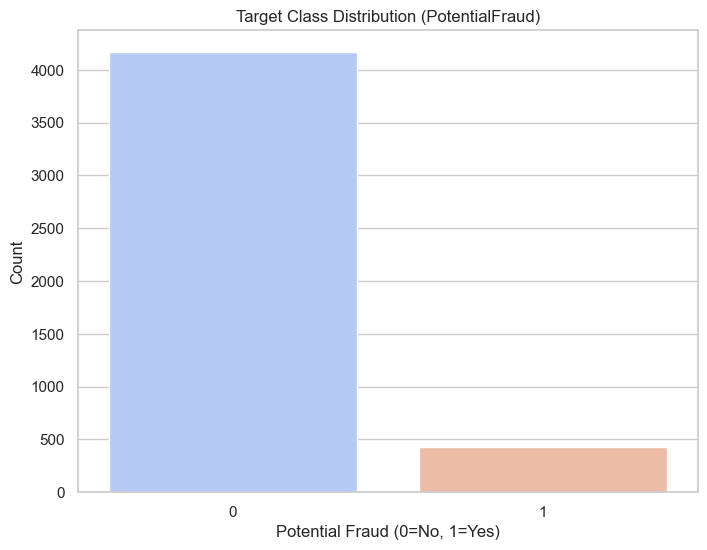

In [137]:
plt.figure(figsize=(8, 6))
sns.countplot(x='PotentialFraud', data=final_df, palette='coolwarm')
plt.title('Target Class Distribution (PotentialFraud)')
plt.xlabel('Potential Fraud (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

2025-12-03 13:44:14,115: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-03 13:44:14,123: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


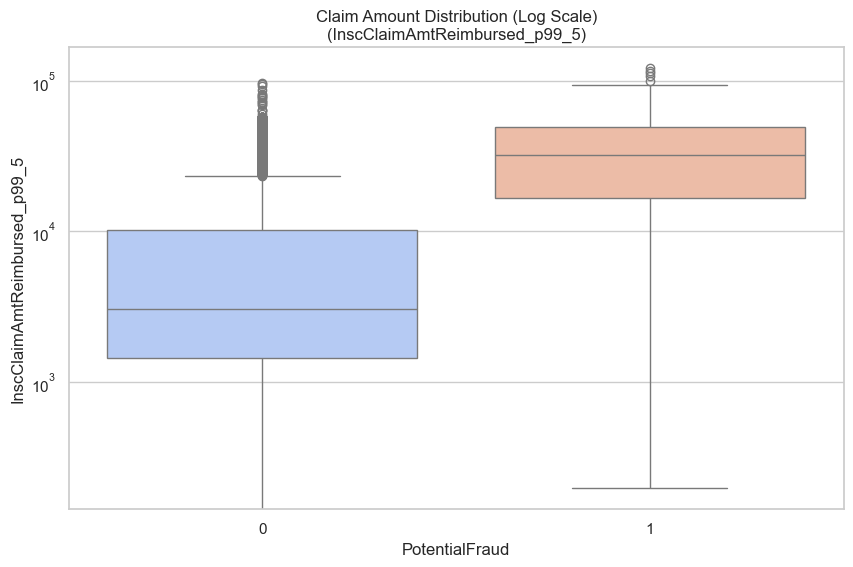

In [138]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='PotentialFraud', y='InscClaimAmtReimbursed_p99_5', data=final_df, palette='coolwarm')

# Log Scale is crucial here
plt.yscale('log')
plt.title('Claim Amount Distribution (Log Scale)\n(InscClaimAmtReimbursed_p99_5)')
plt.show()

2025-12-03 13:44:14,387: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-03 13:44:14,396: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


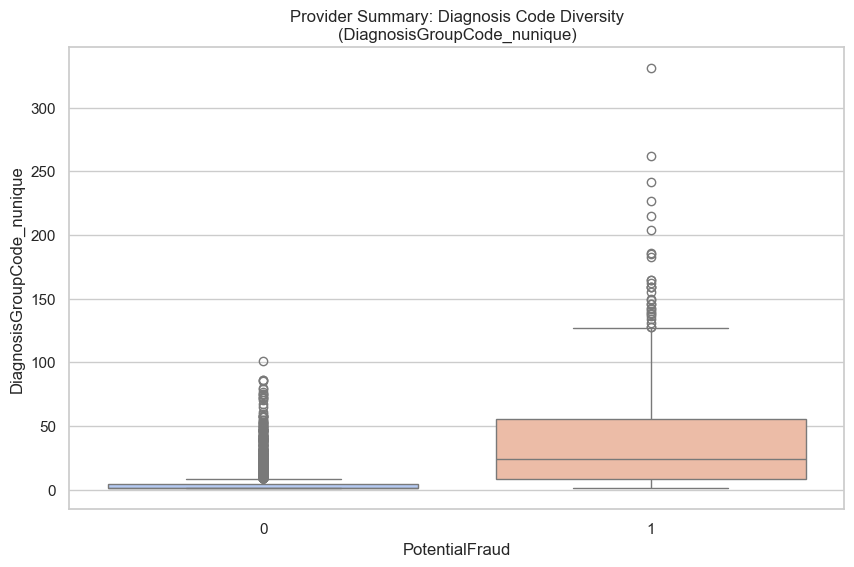

In [139]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='PotentialFraud', y='DiagnosisGroupCode_nunique', data=final_df, palette='coolwarm')
plt.title('Provider Summary: Diagnosis Code Diversity\n(DiagnosisGroupCode_nunique)')
plt.show()

2025-12-03 13:44:14,540: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-03 13:44:14,551: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


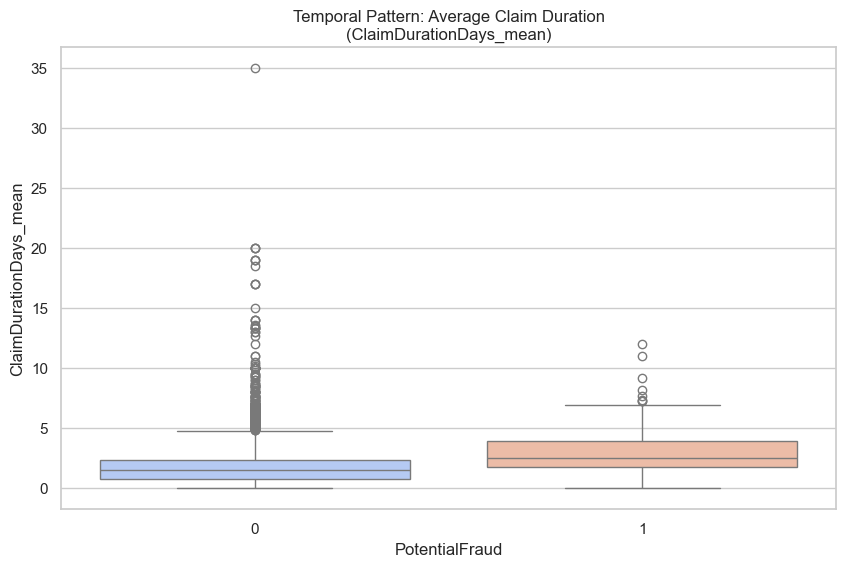

In [140]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='PotentialFraud', y='ClaimDurationDays_mean', data=final_df, palette='coolwarm')
plt.title('Temporal Pattern: Average Claim Duration\n(ClaimDurationDays_mean)')
plt.show()

2025-12-03 13:44:14,691: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-03 13:44:14,697: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


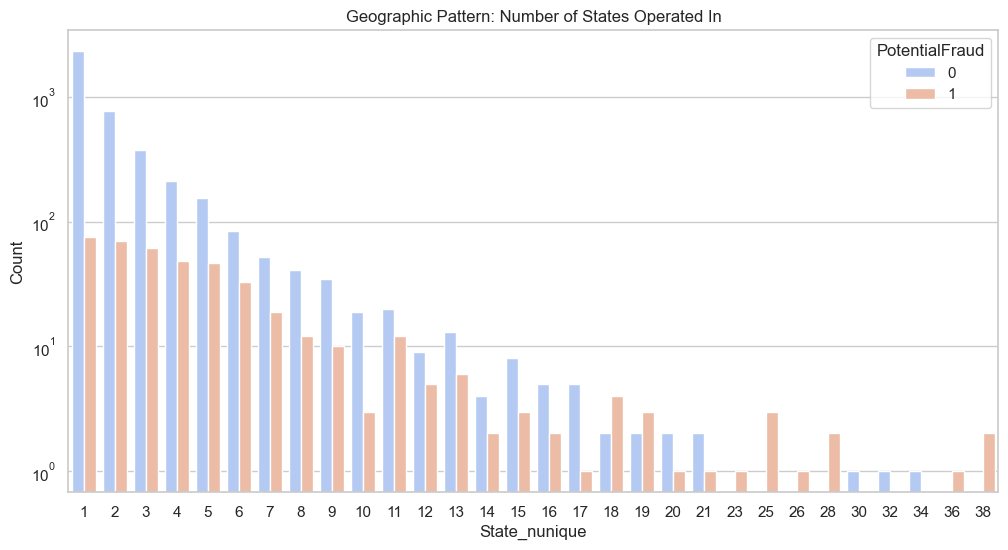

In [141]:
# Prepare the data: count providers by state count and fraud status
state_counts = final_df.groupby(['State_nunique', 'PotentialFraud']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(x='State_nunique', y='Count', hue='PotentialFraud', data=state_counts, palette='coolwarm')

# Log scale helps see the small bars for multi-state providers
plt.yscale('log')
plt.title('Geographic Pattern: Number of States Operated In')
plt.show()

In [142]:
#Final Correlation Matrix
correlation_matrix = final_df.corr(numeric_only=True)
print("Correlation Matrix:")
display(correlation_matrix.style.background_gradient(cmap="coolwarm").format(precision=4))

Correlation Matrix:


# Final file for modeling

In [143]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4598 entries, PRV51001 to PRV57763
Data columns (total 100 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   BeneID_get_mode_count                      4598 non-null   int64  
 1   AttendingPhysician_get_mode_count          4598 non-null   int64  
 2   OperatingPhysician_nunique                 4598 non-null   int64  
 3   OperatingPhysician_get_mode_count          4598 non-null   int64  
 4   OtherPhysician_get_mode_count              4598 non-null   int64  
 5   ClmAdmitDiagnosisCode_nunique              4598 non-null   int64  
 6   DiagnosisGroupCode_nunique                 4598 non-null   int64  
 7   State_nunique                              4598 non-null   int64  
 8   County_Name_nunique                        4598 non-null   int64  
 9   InscClaimAmtReimbursed_mean                4598 non-null   float64
 10  InscClaimAmtReimb

In [144]:
final_df.describe()

BeneID_get_mode_count  AttendingPhysician_get_mode_count  \
count            4598.000000                        4598.000000   
mean                3.588952                          29.072858   
std                 3.451240                          84.662835   
min                 1.000000                           1.000000   
25%                 1.000000                           3.000000   
50%                 2.000000                           8.000000   
75%                 4.000000                          23.000000   
max                28.000000                        2534.000000   

       OperatingPhysician_nunique  OperatingPhysician_get_mode_count  \
count                 4598.000000                        4598.000000   
mean                     6.663767                           6.938669   
std                     11.585832                          17.463164   
min                      0.000000                           0.000000   
25%                      1.000000                           1.000000   
50%                      3.000000                           2.000000   
75%                      8.000000                           6.000000   
max                    297.000000                         424.000000   

       OtherPhysician_get_mode_count  ClmAdmitDiagnosisCode_nunique  \
count                    4598.000000                    4598.000000   
mean                       12.210526                       7.012832   
std                        43.290632                       4.401886   
min                         0.000000                       1.000000   
25%                         1.000000                       3.000000   
50%                         3.000000                       6.000000   
75%                         8.000000                      11.000000   
max                      1098.000000                      17.000000   

       DiagnosisGroupCode_nunique  State_nunique  County_Name_nunique  \
count                 4598.000000    4598.000000          4598.000000   
mean                     7.767508       2.536538             9.415615   
std                     19.820186       2.976865            13.770792   
min                      1.000000       1.000000             1.000000   
25%                      1.000000       1.000000             2.000000   
50%                      1.000000       1.000000             5.000000   
75%                      6.000000       3.000000            11.000000   
max                    331.000000      38.000000           241.000000   

       InscClaimAmtReimbursed_mean  InscClaimAmtReimbursed_p99_5  \
count                  4598.000000                   4598.000000   
mean                   1743.366102                  10750.571966   
std                    3511.186934                  15446.595084   
min                       0.000000                      0.000000   
25%                     233.383978                   1682.775000   
50%                     356.317090                   3217.000000   
75%                    1502.700758                  14436.250000   
max                   57000.000000                 120843.750000   

       DeductibleAmtPaid_std  DeductibleAmtPaid_p99_5  \
count            4598.000000              4598.000000   
mean              121.196160               434.458160   
std               182.945442               492.764929   
min                 0.000000                 0.000000   
25%                 0.000000                 9.150000   
50%                15.339886                96.750000   
75%               238.262331              1068.000000   
max               755.190042              1068.000000   

       IPAnnualReimbursementAmt_mean  IPAnnualReimbursementAmt_std  \
count                    4598.000000                   4598.000000   
mean                     6203.672560                   9759.791549   
std                      6315.319133                   6640.442429   
min                         0.000000             

In [145]:
# Move PotentialFraud to the end
target_col = final_df.pop('PotentialFraud')
final_df['PotentialFraud'] = target_col

In [146]:
final_df.to_csv('../data/final_train_data.csv', index=True)